In [304]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score
import lightgbm as lgb
import xgboost as xgb
from pycaret.classification import *
from preprocessing import Preprocessor
import sweetviz as sv

%matplotlib inline

#### Data Load & Describtion

##### Load data & check

In [305]:
train_df = pd.read_csv('playground-series-s4e10/train.csv')
test_df = pd.read_csv('playground-series-s4e10/test.csv')

print(f'Training data shape:{train_df.shape}')
print(f'Testing data shape:{test_df.shape}')
train_df.isna().sum()

Training data shape:(58645, 13)
Testing data shape:(39098, 12)


id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [306]:
train_df.dtypes

id                              int64
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object

#### Check data type and classification object or not

In [307]:
TARGET = 'loan_status'
object_columns = train_df.select_dtypes('object').columns.tolist()
int_columns = train_df.drop(columns='id').select_dtypes('int64').columns.tolist()
float_columns = train_df.select_dtypes('float64').columns.tolist()
for i in train_df.drop(columns=['id']).columns:
    print(f'{i}: {train_df[i].nunique()}')
    print(f'{train_df[i].dtype}\n')
    if train_df[i].dtype == 'object':
        print(f'{train_df[i].unique()}\n\n')
    
        
print(f'\nobject columns：{object_columns}')
print(f'\nint columns：{int_columns}')
print(f'\nfloat columns：{float_columns}')

person_age: 53
int64

person_income: 2641
int64

person_home_ownership: 4
object

['RENT' 'OWN' 'MORTGAGE' 'OTHER']


person_emp_length: 36
float64

loan_intent: 6
object

['EDUCATION' 'MEDICAL' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']


loan_grade: 7
object

['B' 'C' 'A' 'D' 'E' 'F' 'G']


loan_amnt: 545
int64

loan_int_rate: 362
float64

loan_percent_income: 61
float64

cb_person_default_on_file: 2
object

['N' 'Y']


cb_person_cred_hist_length: 29
int64

loan_status: 2
int64


object columns：['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

int columns：['person_age', 'person_income', 'loan_amnt', 'cb_person_cred_hist_length', 'loan_status']

float columns：['person_emp_length', 'loan_int_rate', 'loan_percent_income']


##### use sweetviz see different group data different

In [309]:
# Generate a Sweetviz report for the training dataset
# report = sv.analyze(train_df)

# Display the report
# Generate a Sweetviz report for the training dataset, split by the 'loan_status' column
report = sv.compare([train_df[train_df[TARGET] == 0].drop(columns='id'), "Loan Status 0"],
                    [train_df[train_df[TARGET] == 1].drop(columns='id'), "Loan Status 1"])

# Display the report
report.show_html('sweetviz_report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


##### use correlation heatmap see float and int data column correlation

<Axes: >

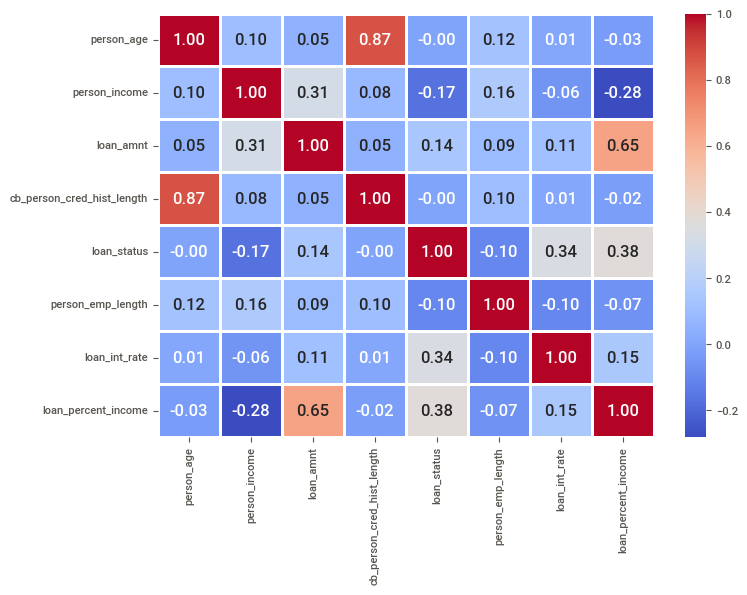

In [310]:
sns.heatmap(train_df[int_columns + float_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)

##### see different pattern in approve or not approve in category columns 

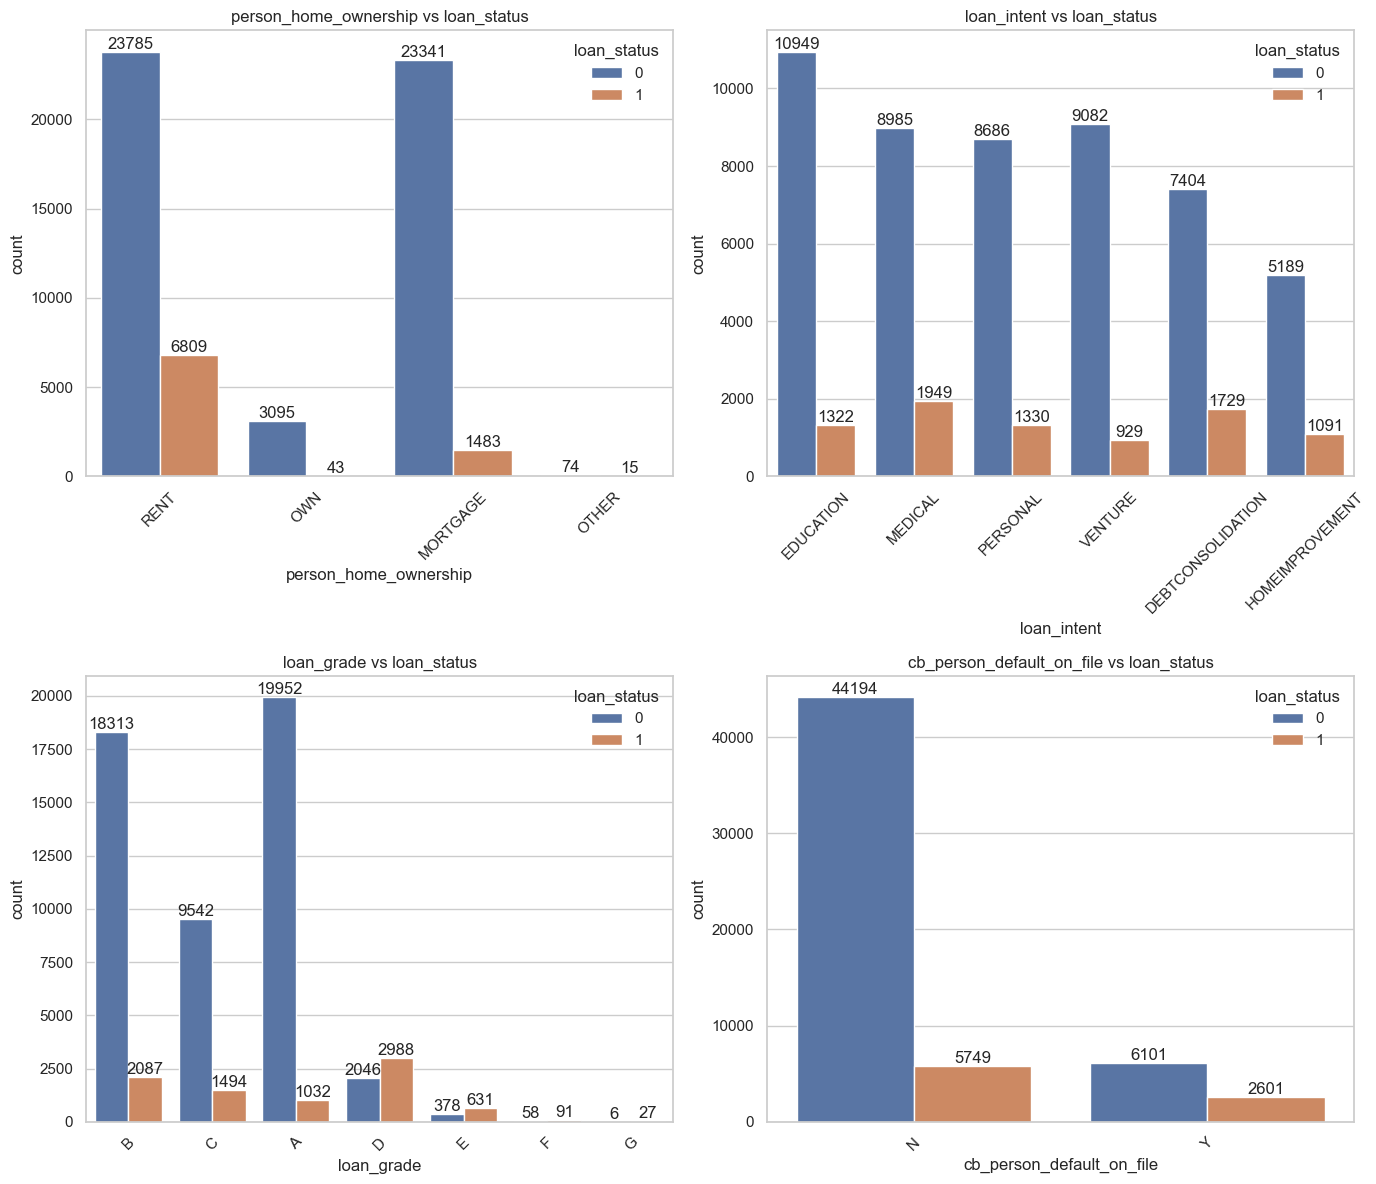

In [311]:
sns.set(style="whitegrid")
n_cols = 2  
n_rows = (len(object_columns) + n_cols - 1) // n_cols  # 計算行數

# 創建繪圖區域
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6 * n_rows))

# 迴圈遍歷每個分類欄位，生成對應的圖表
for i, column in enumerate(object_columns):
    row = i // n_cols
    col = i % n_cols
    sns.countplot(x=column, hue=TARGET, data=train_df, ax=axes[row, col])
    axes[row, col].set_title(f'{column} vs {TARGET}')
    axes[row, col].tick_params(axis='x', rotation=45)

# 如果子圖數量小於網格數，則隱藏多餘的子圖
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

# 顯示數字
for ax in axes.flat:
    for container in ax.containers:
        ax.bar_label(container)
        
        
plt.tight_layout()
plt.show()

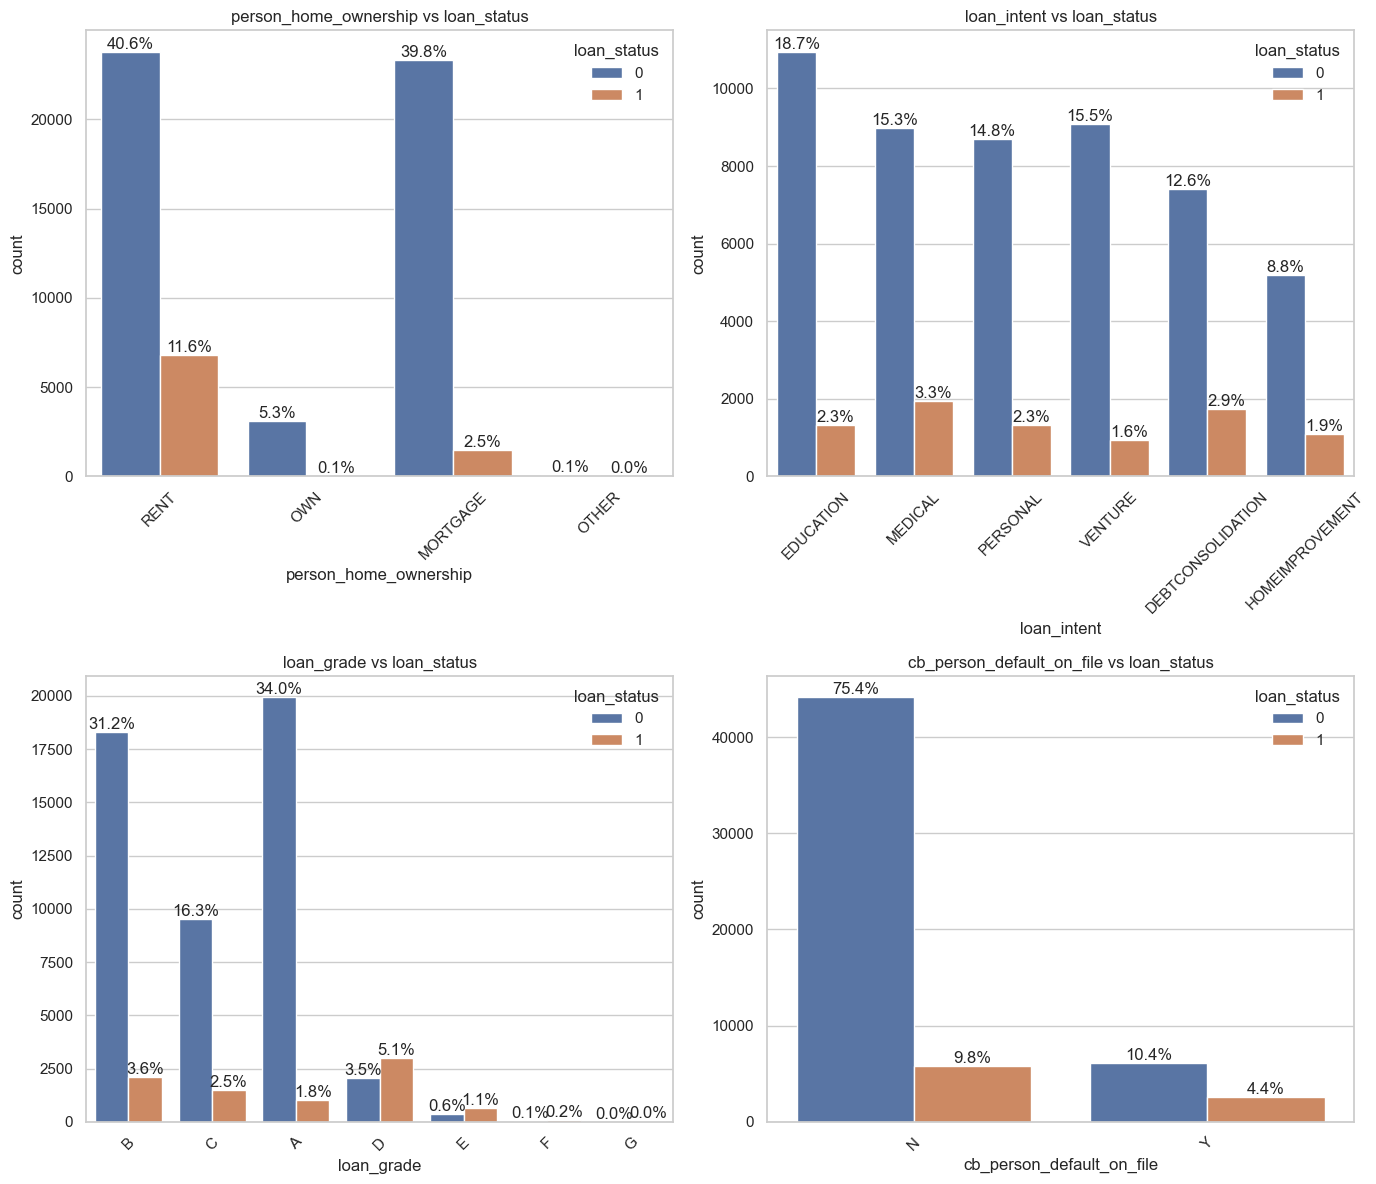

In [312]:
sns.set(style="whitegrid")
n_cols = 2  
n_rows = (len(object_columns) + n_cols - 1) // n_cols  # 計算行數

# 創建繪圖區域
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6 * n_rows))

# 迴圈遍歷每個分類欄位，生成對應的圖表
for i, column in enumerate(object_columns):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    
    # 計算百分比
    total = train_df.groupby(column)[TARGET].count()
    sns.countplot(x=column, hue=TARGET, data=train_df, ax=ax)
    
    for container in ax.containers:
        labels = []
        for v in container:
            percentage = (v.get_height() / total.sum()) * 100
            labels.append(f'{percentage:.1f}%')
        ax.bar_label(container, labels=labels)
    
    ax.set_title(f'{column} vs {TARGET}')
    ax.tick_params(axis='x', rotation=45)

# 如果子圖數量小於網格數，則隱藏多餘的子圖
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

plt.tight_layout()
plt.show()
plt.show()

##### see continue columns' performance in approve loan group 

In [313]:
train_df[train_df[TARGET]==0].drop(columns=['id',TARGET]).describe().round(2).T

count      mean       std      min       25%  \
person_age                  50295.0     27.55      5.98    20.00     23.00   
person_income               50295.0  66672.87  39314.38  4200.00  45000.00   
person_emp_length           50295.0      4.86      3.95     0.00      2.00   
loan_amnt                   50295.0   8888.88   5328.36   500.00   5000.00   
loan_int_rate               50295.0     10.26      2.83     5.42      7.51   
loan_percent_income         50295.0      0.15      0.08     0.00      0.08   
cb_person_cred_hist_length  50295.0      5.82      4.00     2.00      3.00   

                                 50%       75%         max  
person_age                     26.00     30.00      123.00  
person_income               60000.00  80000.00  1900000.00  
person_emp_length               4.00      7.00      123.00  
loan_amnt                    8000.00  12000.00    35000.00  
loan_int_rate                  10.39     12.42       22.11  
loan_percent_income             0.13      0.20        0.63  
cb_person_cred_hist_length      4.00      8.00       30.00

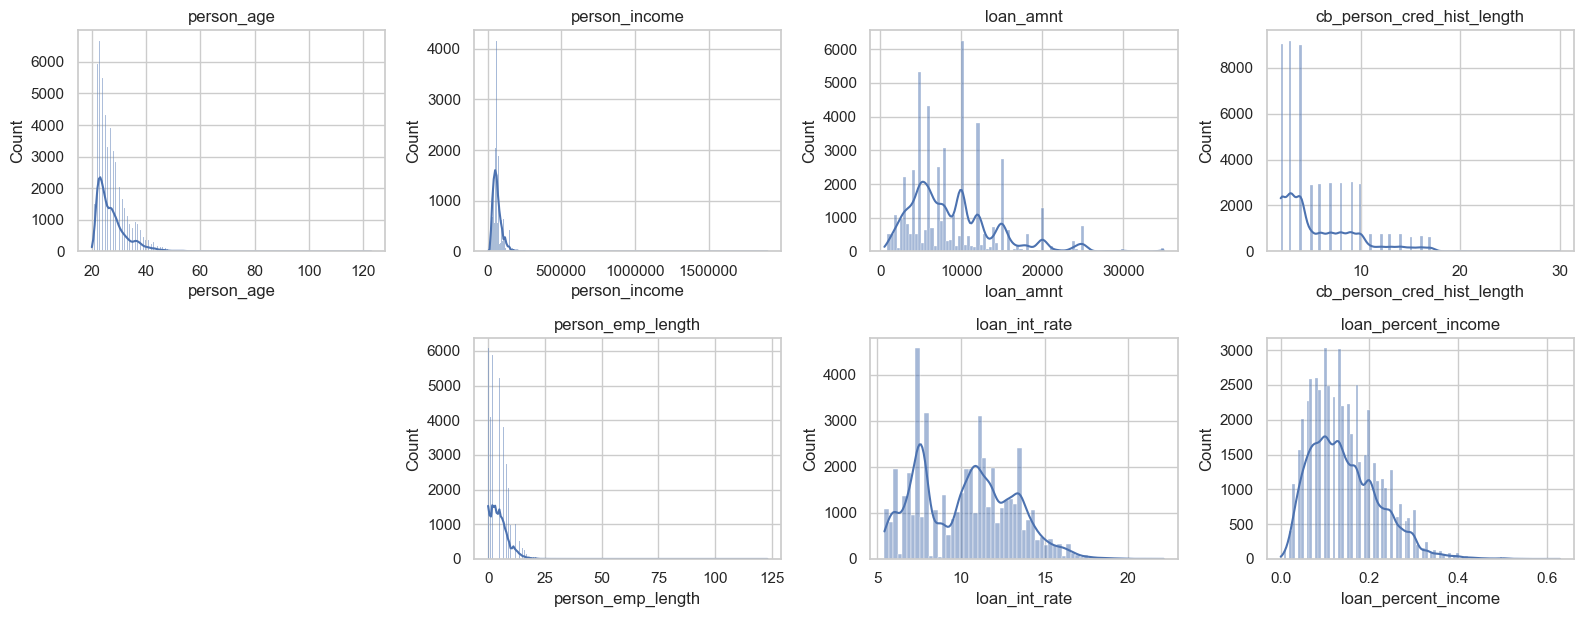

In [314]:
plt.figure(figsize=(16,12))
for count, col in enumerate(int_columns + float_columns):
    if col != TARGET:
        plt.subplot(4, 4, count + 1)
        sns.histplot(train_df[train_df[TARGET]==0][col], kde=True)
        plt.title(col)
        plt.tight_layout()
        


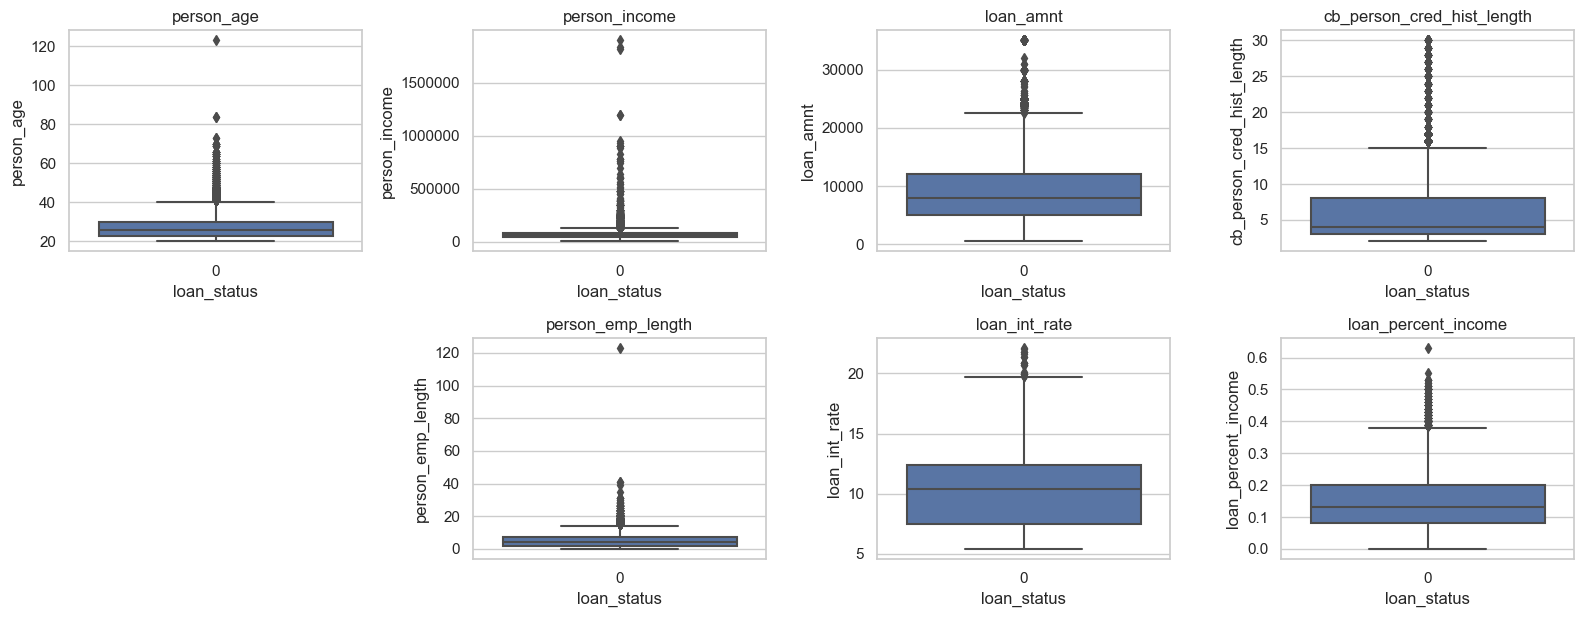

In [315]:
plt.figure(figsize=(16, 12))
for count, col in enumerate(int_columns + float_columns):
    if col != TARGET:
        plt.subplot(4, 4, count + 1)
        sns.boxplot(x=TARGET, y=col, data=train_df[train_df[TARGET]==0])
        plt.title(col)
        plt.tight_layout()

##### see drop outlier different or not

In [316]:
# # 計算 IQR
# Q1 = train_df.drop(columns=['id',TARGET]).quantile(0.25)
# Q3 = train_df.drop(columns=['id',TARGET]).quantile(0.75)
# IQR = Q3 - Q1
# # 定義異常值範圍
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # 去除異常值
# df_cleaned = train_df[~((train_df < lower_bound) | (train_df > upper_bound)).any(axis=1)]

In [181]:
# print(lower_bound)
# print(f'\n{upper_bound}')

person_age                      12.500
person_income                -8400.000
person_emp_length               -5.500
loan_amnt                    -5500.000
loan_int_rate                    0.215
loan_percent_income             -0.090
cb_person_cred_hist_length      -4.500
dtype: float64

person_age                        40.500
person_income                 126000.000
person_emp_length                 14.500
loan_amnt                      22500.000
loan_int_rate                     20.655
loan_percent_income                0.390
cb_person_cred_hist_length        15.500
dtype: float64


In [182]:
# df_cleaned[df_cleaned[TARGET]==1]

id  person_age  person_income person_home_ownership  \
11        11          22          33000                  RENT   
24        24          22          30000                  RENT   
25        25          25          25000                  RENT   
38        38          30          54000                  RENT   
39        39          22          32000                  RENT   
...      ...         ...            ...                   ...   
58632  58632          23          29654                  RENT   
58635  58635          32          69000                  RENT   
58638  58638          29          46610              MORTGAGE   
58641  58641          28          28800                  RENT   
58642  58642          23          44000                  RENT   

       person_emp_length        loan_intent loan_grade  loan_amnt  \
11                   6.0           PERSONAL          B      10000   
24                   3.0            MEDICAL          D       5000   
25                   3.0            VENTURE          C       3500   
38                   0.0            MEDICAL          B      12500   
39                   6.0          EDUCATION          D       8000   
...                  ...                ...        ...        ...   
58632                1.0            VENTURE          A      10000   
58635                0.0  DEBTCONSOLIDATION          B      12000   
58638                1.0           PERSONAL          D       2600   
58641                0.0            MEDICAL          C      10000   
58642                7.0          EDUCATION          D       6800   

       loan_int_rate  loan_percent_income cb_person_default_on_file  \
11             11.12                 0.30                         N   
24             16.49                 0.17                         N   
25             13.49                 0.14                         Y   
38             11.71                 0.24                         N   
39             15.58                 0.25                         N   
...              ...                  ...                       ...   
58632           6.54                 0.34                         N   
58635          10.20                 0.17                         N   
58638          17.58                 0.05                         N   
58641          12.73                 0.35                         N   
58642          16.00                 0.15                         N   

       cb_person_cred_hist_length  loan_status  
11                              2            1  
24                              4            1  
25                              3            1  
38                             10            1  
39                              3            1  
...                           ...          ...  
58632                           2            1  
58635                           7            1  
58638                           6            1  
58641                           8            1  
58642                           2            1  

[6415 rows x 13 columns]

In [183]:
# df_cleaned.shape

(49882, 13)

In [184]:
# df_cleaned[df_cleaned[TARGET]==0].drop(columns=['id',TARGET]).describe().round(2).T

count      mean       std      min       25%  \
person_age                  43467.0     26.36      4.18    20.00     23.00   
person_income               43467.0  60756.45  23231.32  4200.00  43000.00   
person_emp_length           43467.0      4.53      3.39     0.00      2.00   
loan_amnt                   43467.0   8214.41   4394.52   500.00   5000.00   
loan_int_rate               43467.0     10.22      2.80     5.42      7.51   
loan_percent_income         43467.0      0.14      0.07     0.00      0.09   
cb_person_cred_hist_length  43467.0      5.09      3.02     2.00      3.00   

                                 50%       75%        max  
person_age                     25.00     29.00      40.00  
person_income               58125.00  75000.00  126000.00  
person_emp_length               4.00      7.00      14.00  
loan_amnt                    7500.00  10000.00   22500.00  
loan_int_rate                  10.38     12.42      20.11  
loan_percent_income             0.13      0.19       0.39  
cb_person_cred_hist_length      4.00      7.00      15.00

In [187]:
# df_cleaned[df_cleaned[TARGET]==1].drop(columns=['id',TARGET]).describe().round(2).T

count      mean       std      min       25%  \
person_age                  6415.0     26.30      4.26    20.00     23.00   
person_income               6415.0  46232.09  18244.61  9600.00  32000.00   
person_emp_length           6415.0      3.44      3.12     0.00      1.00   
loan_amnt                   6415.0   9555.63   5009.85  1000.00   5000.00   
loan_int_rate               6415.0     13.32      2.96     5.42     11.36   
loan_percent_income         6415.0      0.22      0.10     0.01      0.13   
cb_person_cred_hist_length  6415.0      5.02      3.06     2.00      3.00   

                                 50%       75%        max  
person_age                     25.00     29.00      40.00  
person_income               44000.00  56000.00  124886.00  
person_emp_length               3.00      5.00      14.00  
loan_amnt                    9500.00  12800.00   22400.00  
loan_int_rate                  13.99     15.62      20.62  
loan_percent_income             0.21      0.32       0.39  
cb_person_cred_hist_length      4.00      7.00      15.00

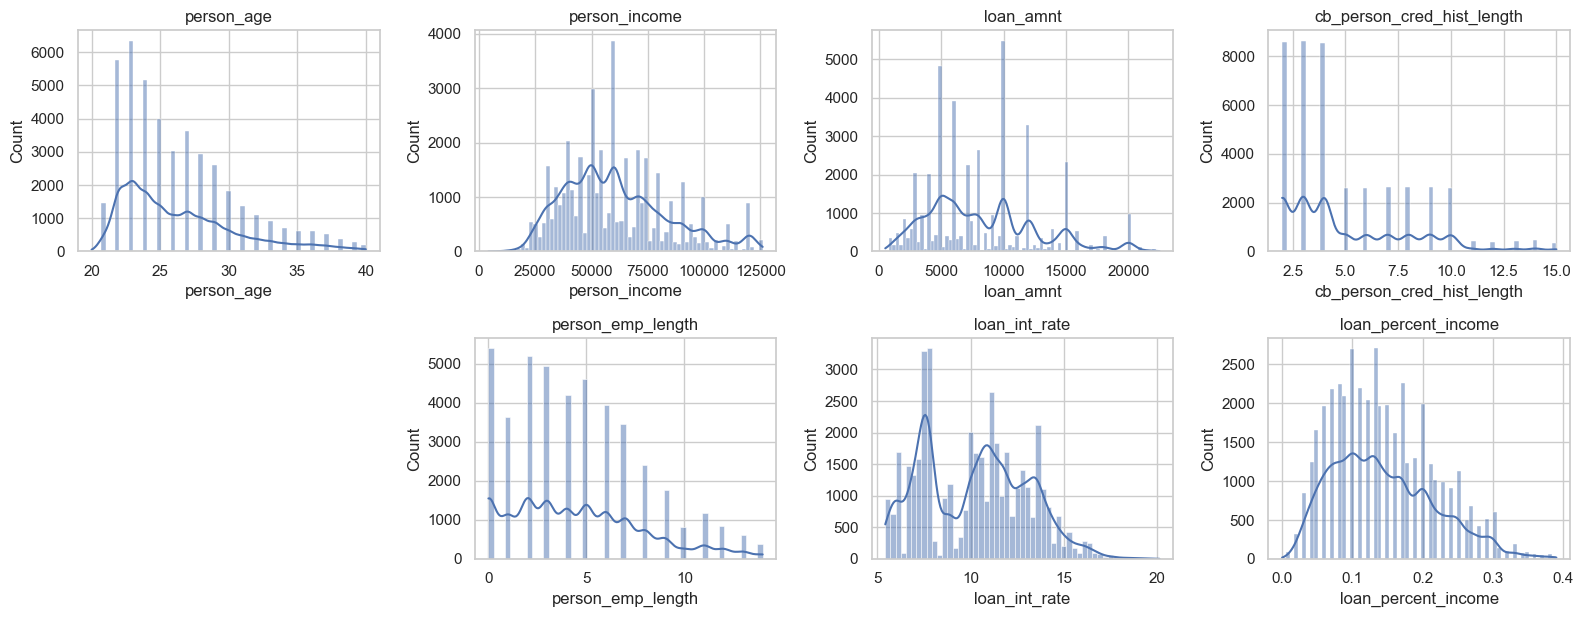

In [185]:
# plt.figure(figsize=(16,12))
# for count, col in enumerate(int_columns + float_columns):
#     if col != TARGET:
#         plt.subplot(4, 4, count + 1)
#         sns.histplot(df_cleaned[df_cleaned[TARGET]==0][col], kde=True)
#         plt.title(col)
#         plt.tight_layout()
        

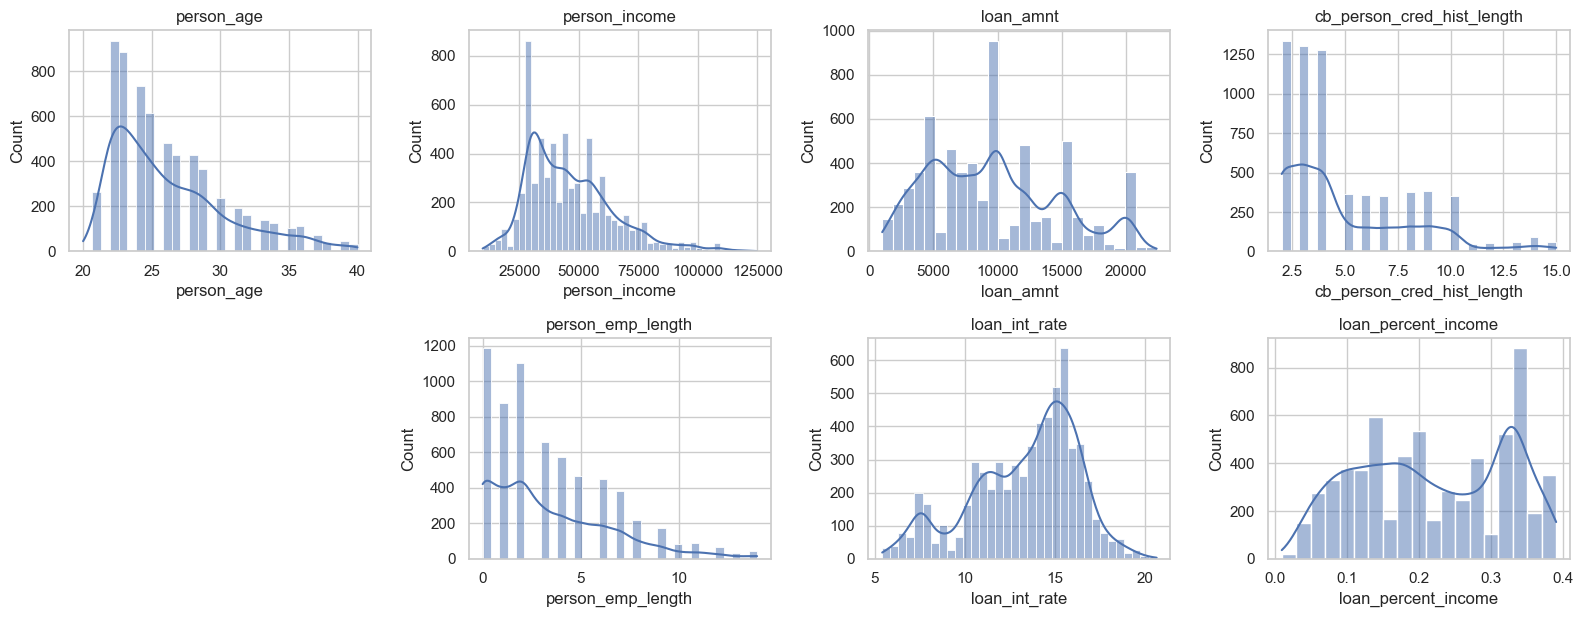

In [188]:
# plt.figure(figsize=(16,12))
# for count, col in enumerate(int_columns + float_columns):
#     if col != TARGET:
#         plt.subplot(4, 4, count + 1)
#         sns.histplot(df_cleaned[df_cleaned[TARGET]==1][col], kde=True)
#         plt.title(col)
#         plt.tight_layout()
        

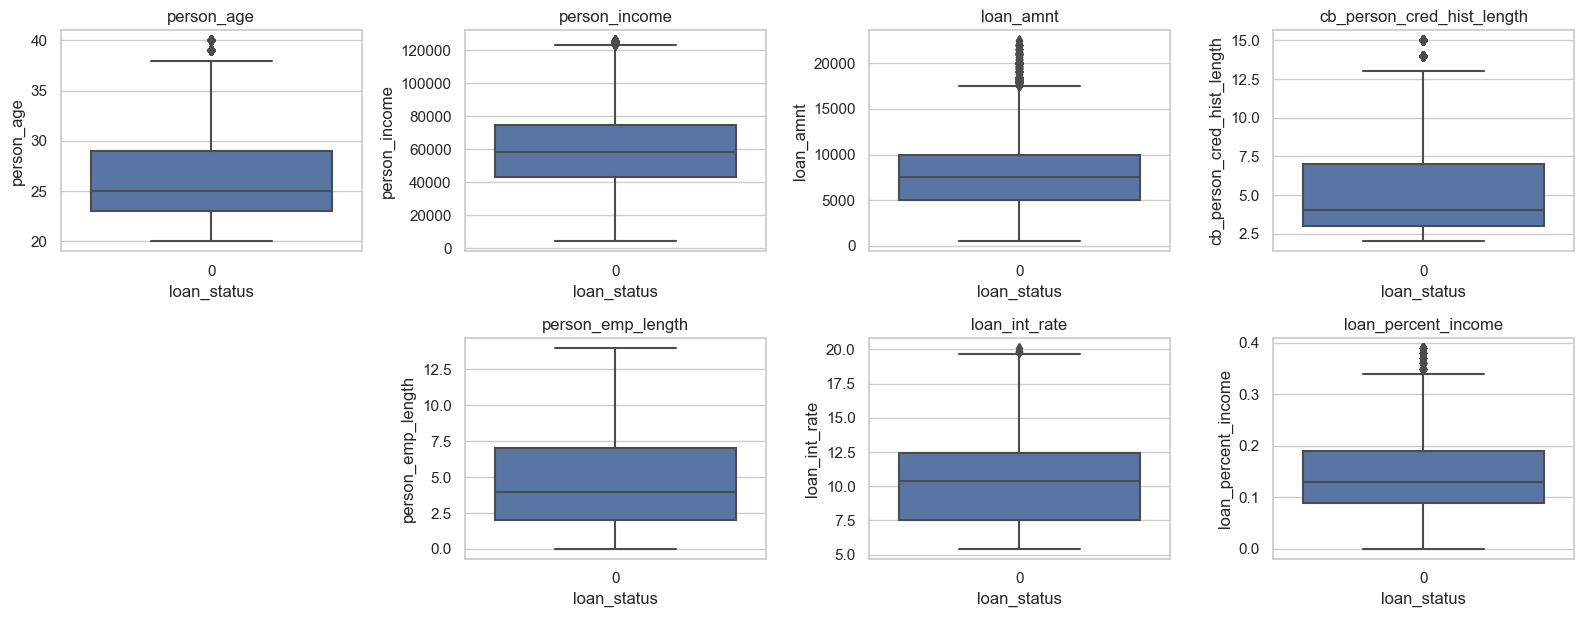

In [186]:
# plt.figure(figsize=(16, 12))
# for count, col in enumerate(int_columns + float_columns):
#     if col != TARGET:
#         plt.subplot(4, 4, count + 1)
#         sns.boxplot(x=TARGET, y=col, data=df_cleaned[df_cleaned[TARGET]==0])
#         plt.title(col)
#         plt.tight_layout()

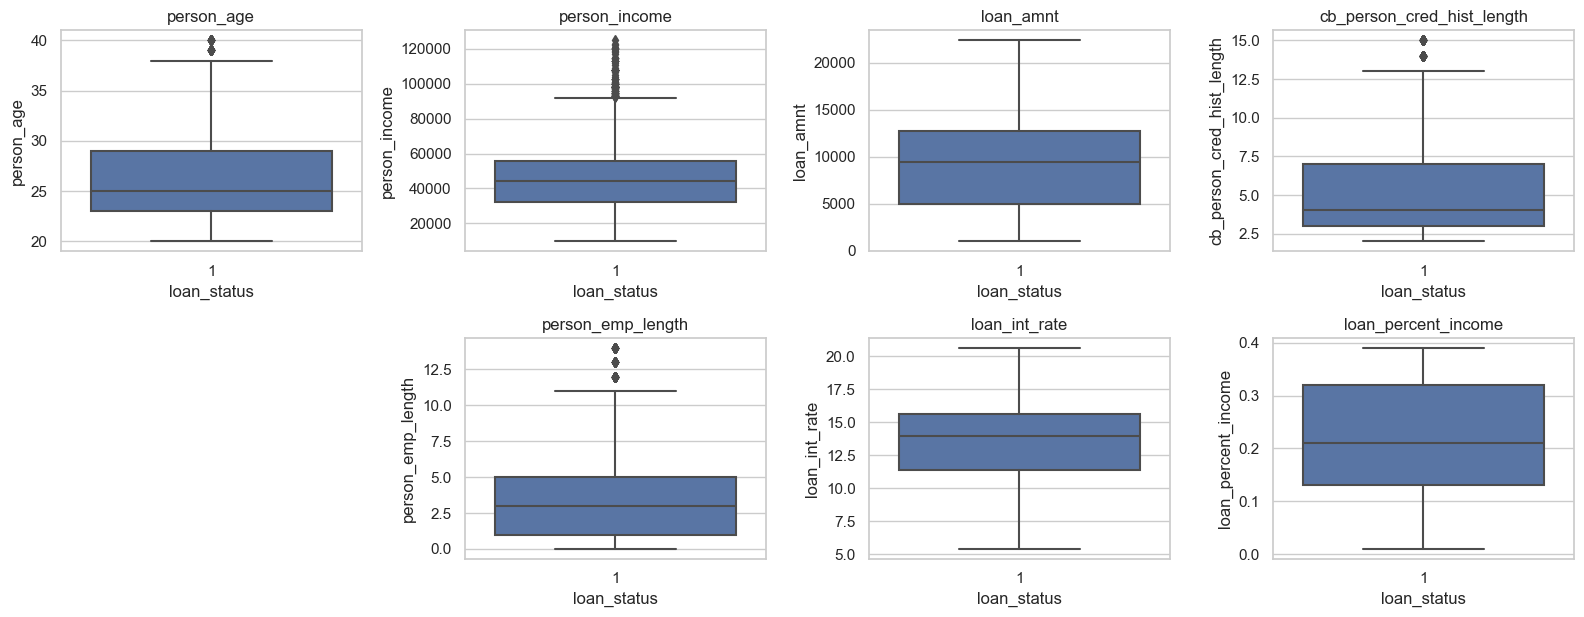

In [189]:
# plt.figure(figsize=(16, 12))
# for count, col in enumerate(int_columns + float_columns):
#     if col != TARGET:
#         plt.subplot(4, 4, count + 1)
#         sns.boxplot(x=TARGET, y=col, data=df_cleaned[df_cleaned[TARGET]==1])
#         plt.title(col)
#         plt.tight_layout()

In [175]:
# df_not_cleaned = train_df[~train_df['id'].isin(df_cleaned['id'])]

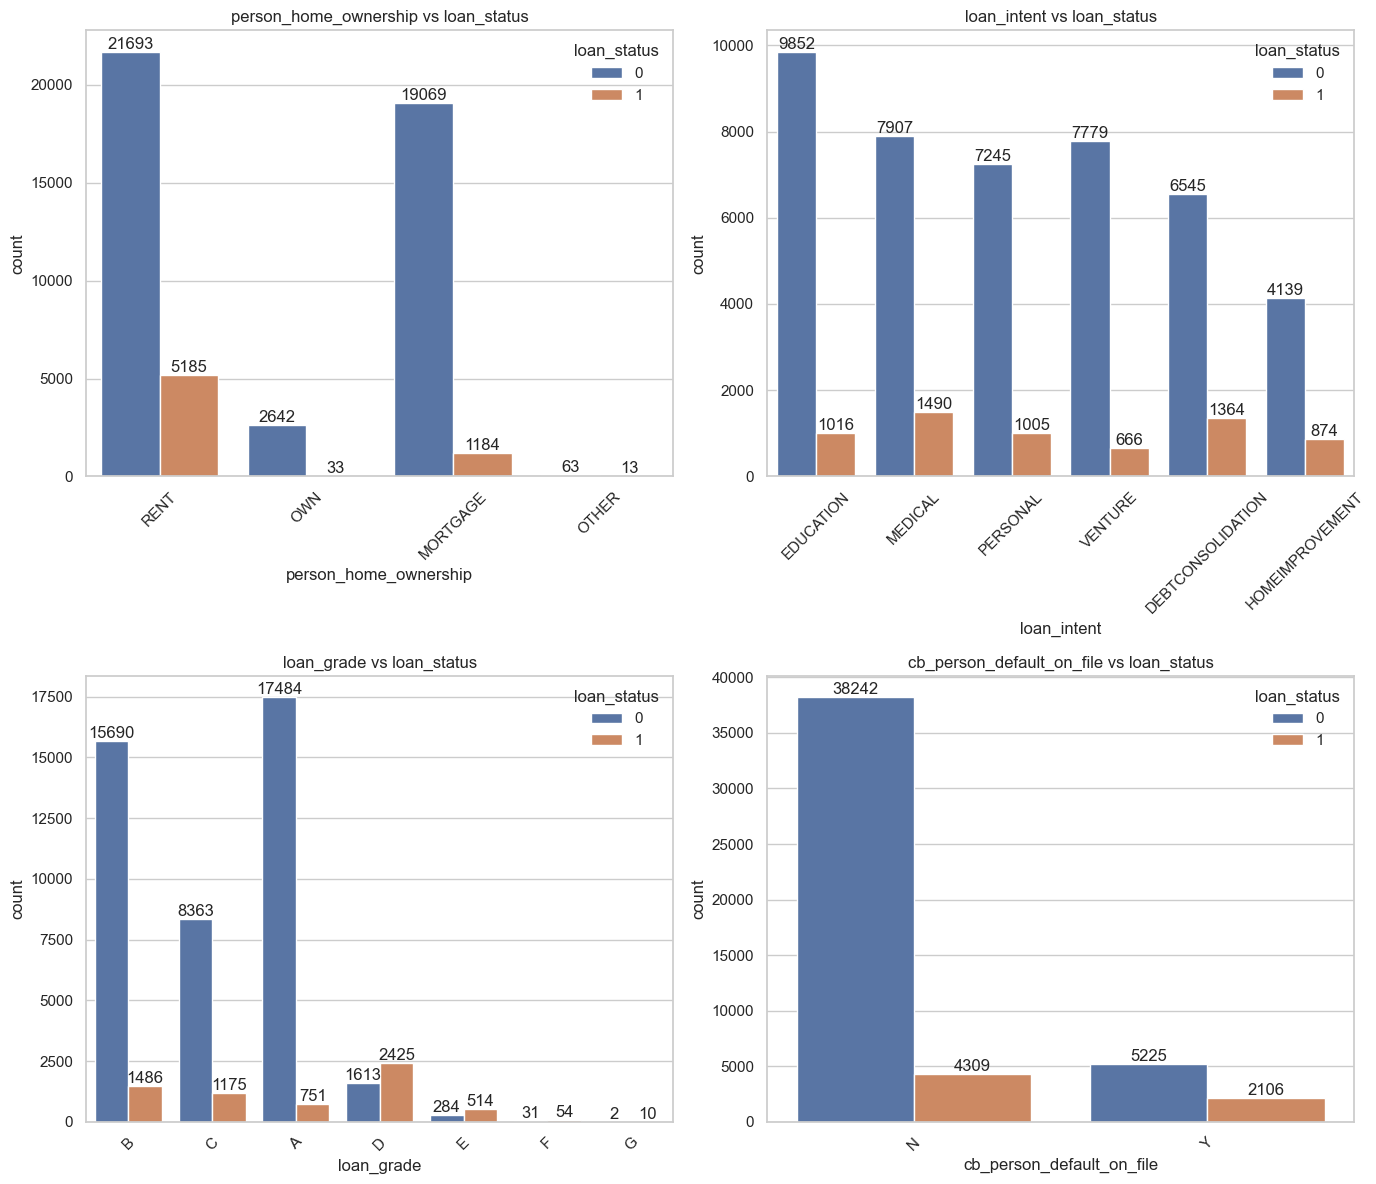

In [190]:
# sns.set(style="whitegrid")
# n_cols = 2  
# n_rows = (len(object_columns) + n_cols - 1) // n_cols  # 計算行數

# # 創建繪圖區域
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6 * n_rows))

# # 迴圈遍歷每個分類欄位，生成對應的圖表
# for i, column in enumerate(object_columns):
#     row = i // n_cols
#     col = i % n_cols
#     sns.countplot(x=column, hue=TARGET, data=df_cleaned, ax=axes[row, col])
#     axes[row, col].set_title(f'{column} vs {TARGET}')
#     axes[row, col].tick_params(axis='x', rotation=45)

# # 如果子圖數量小於網格數，則隱藏多餘的子圖
# for j in range(i + 1, n_rows * n_cols):
#     fig.delaxes(axes[j // n_cols, j % n_cols])

# # 顯示數字
# for ax in axes.flat:
#     for container in ax.containers:
#         ax.bar_label(container)
        
        
# plt.tight_layout()
# plt.show()

###### see different loan grade cate col performance

Rank: B



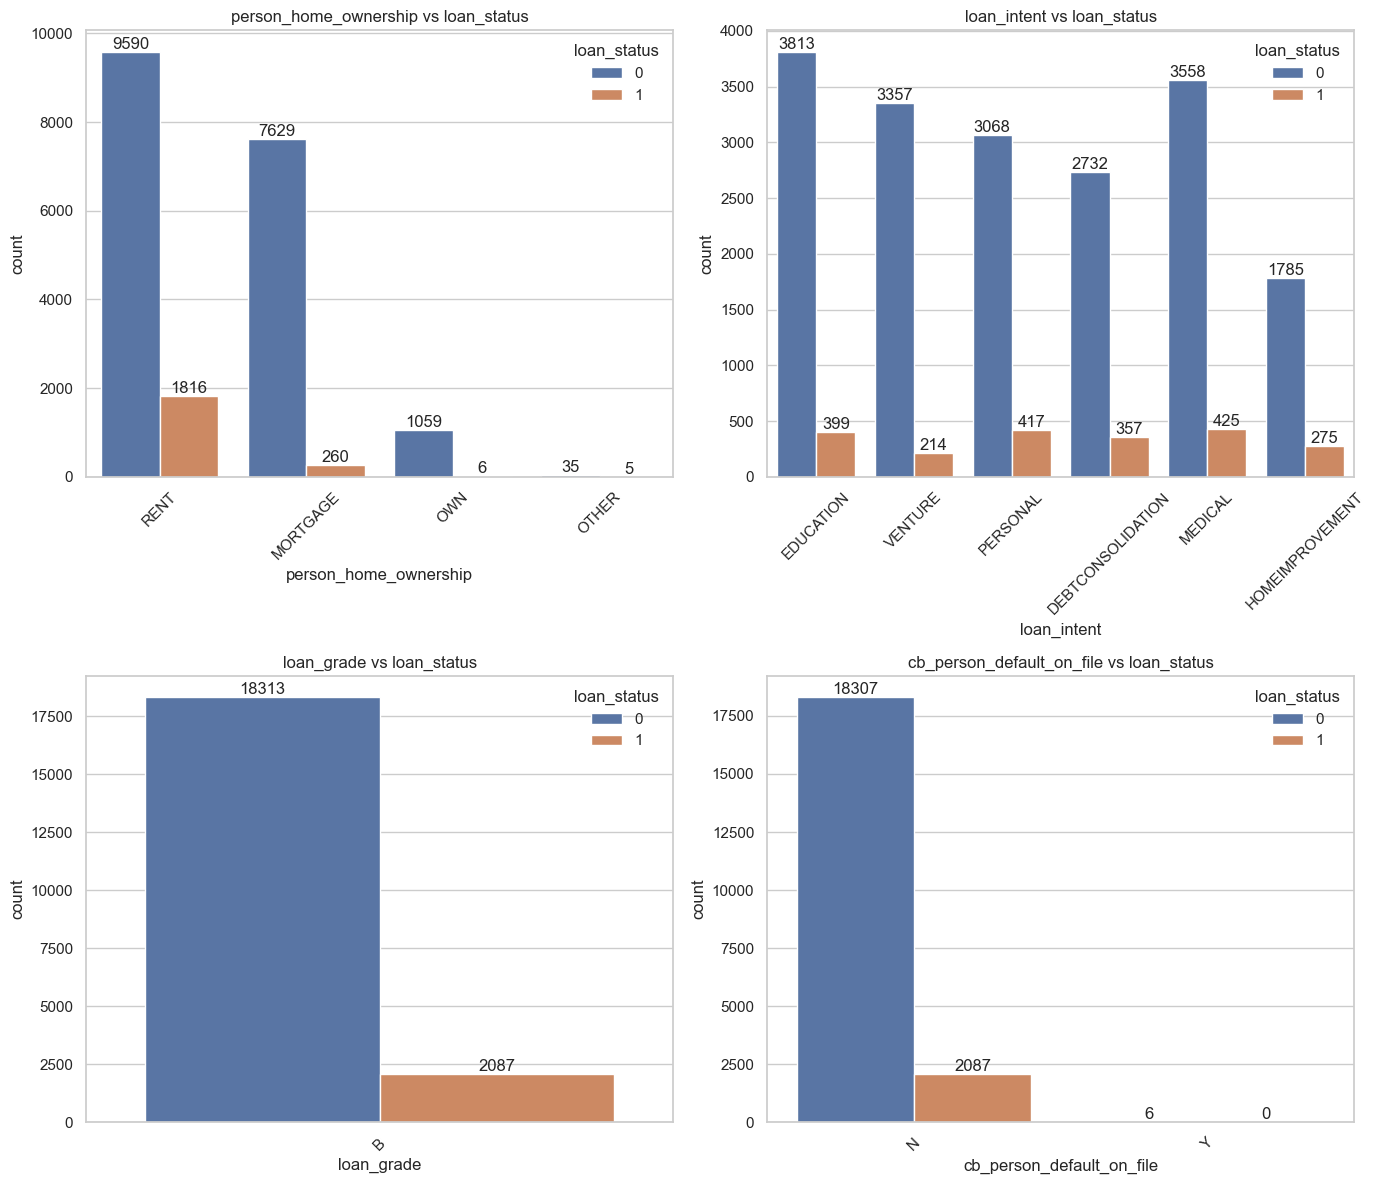




Rank: C



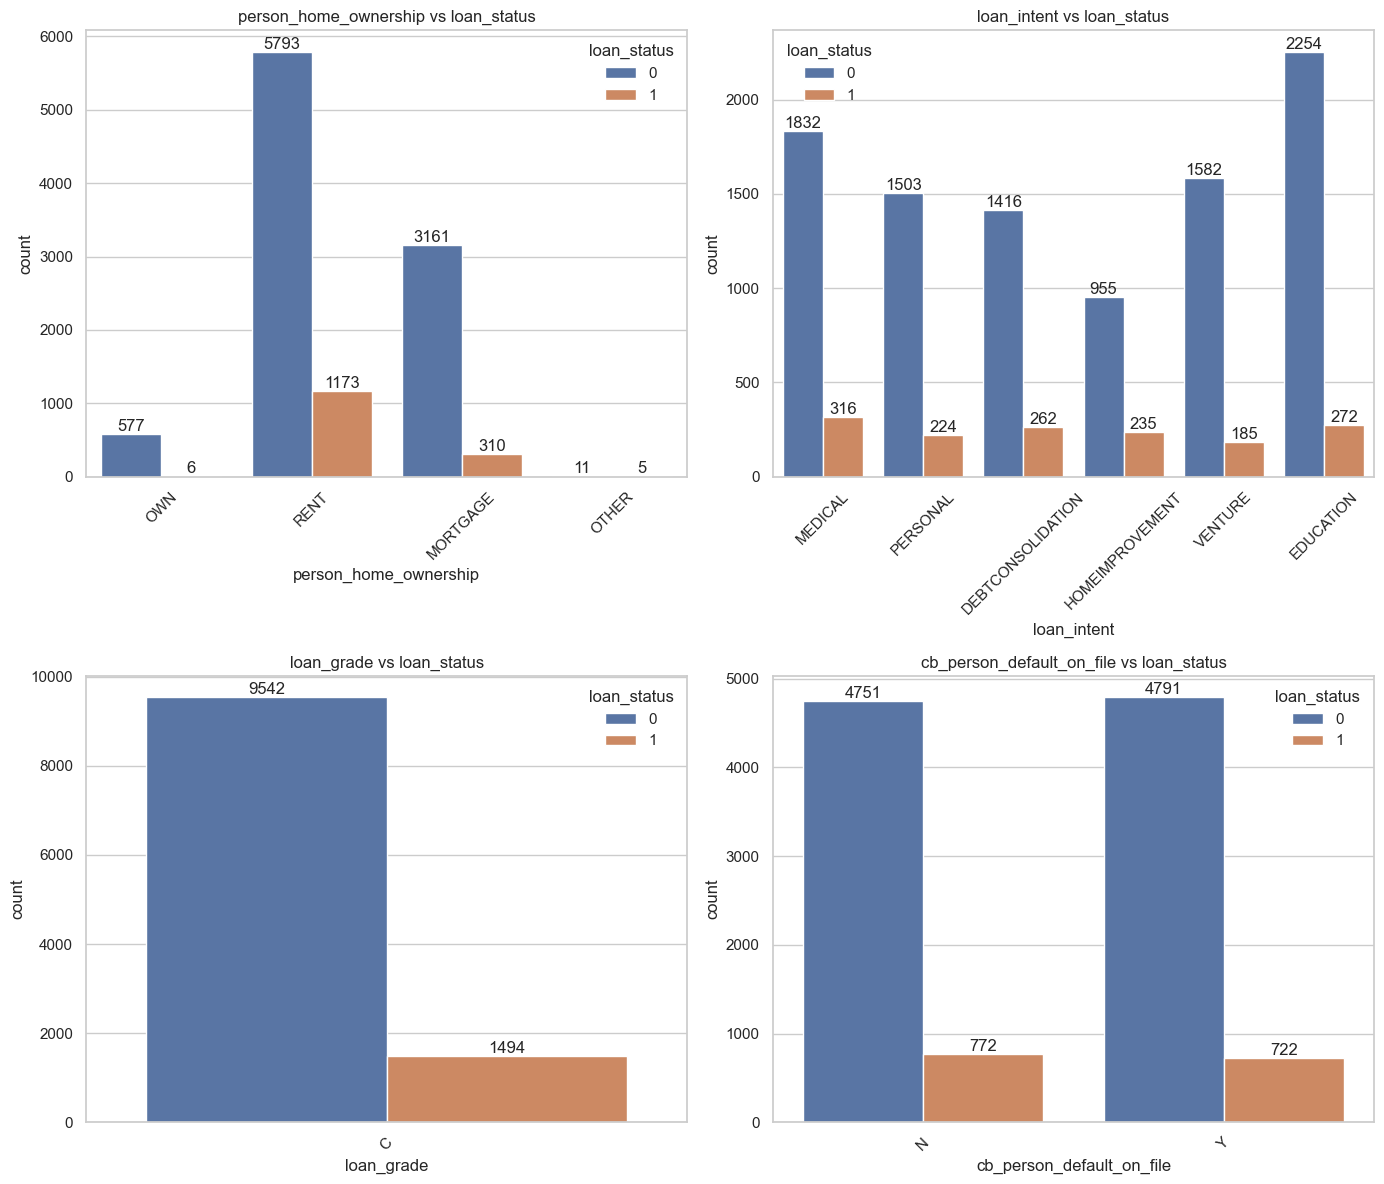




Rank: A



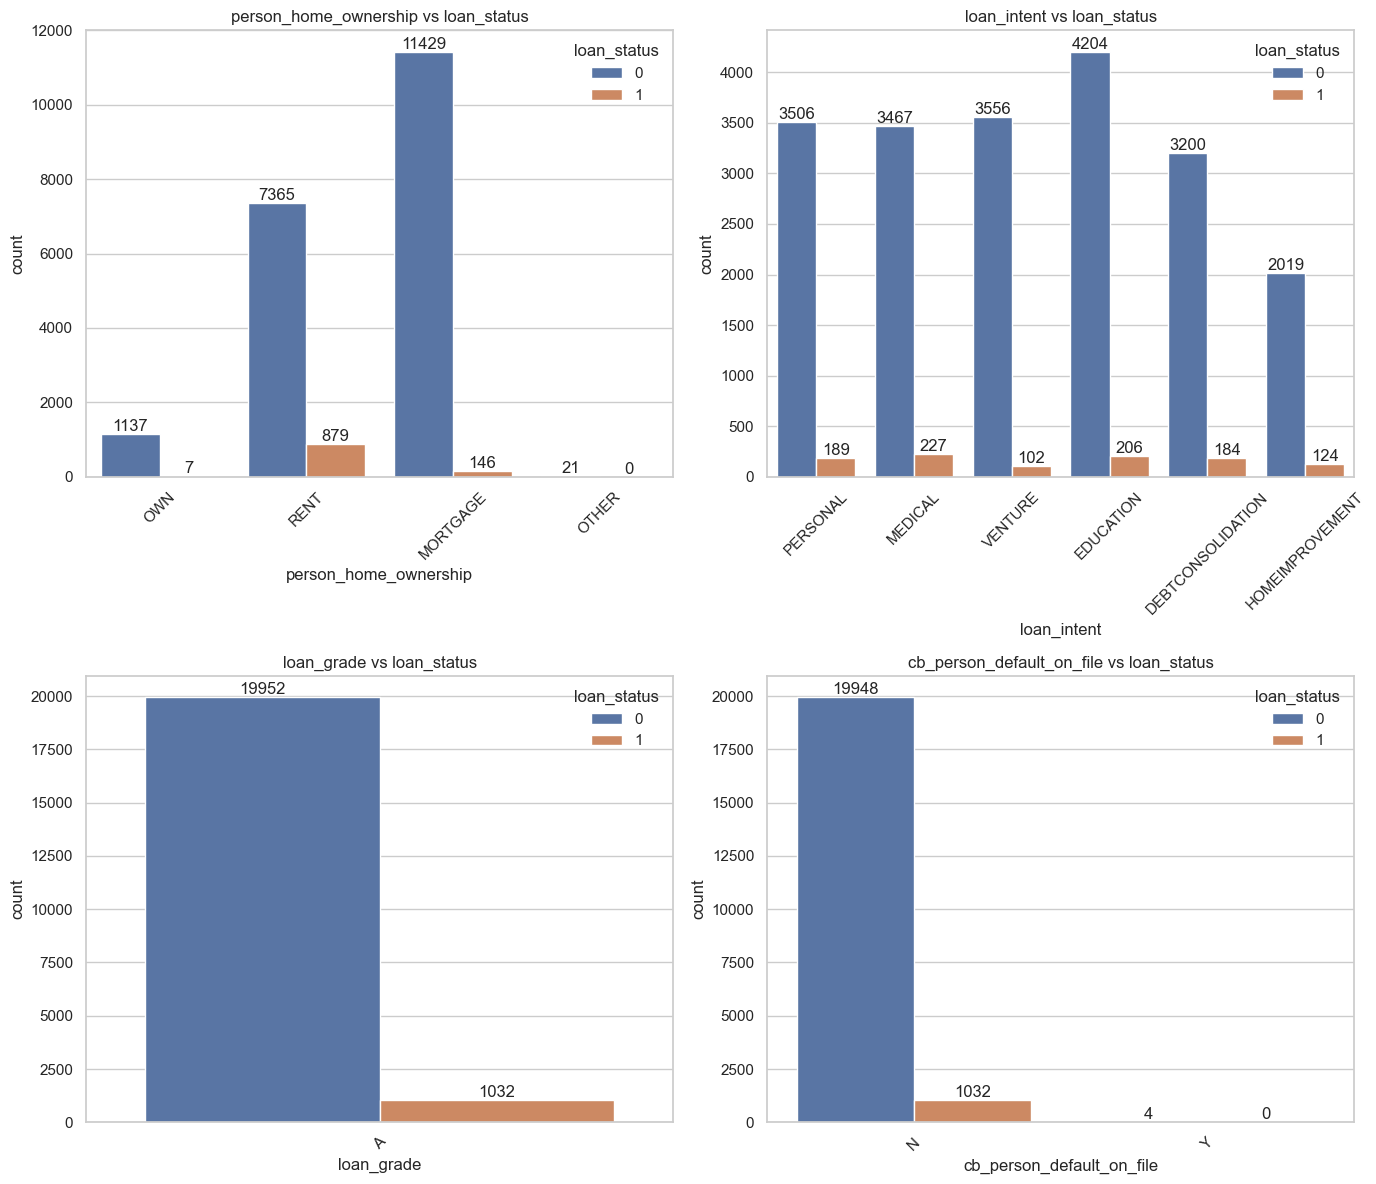




Rank: D



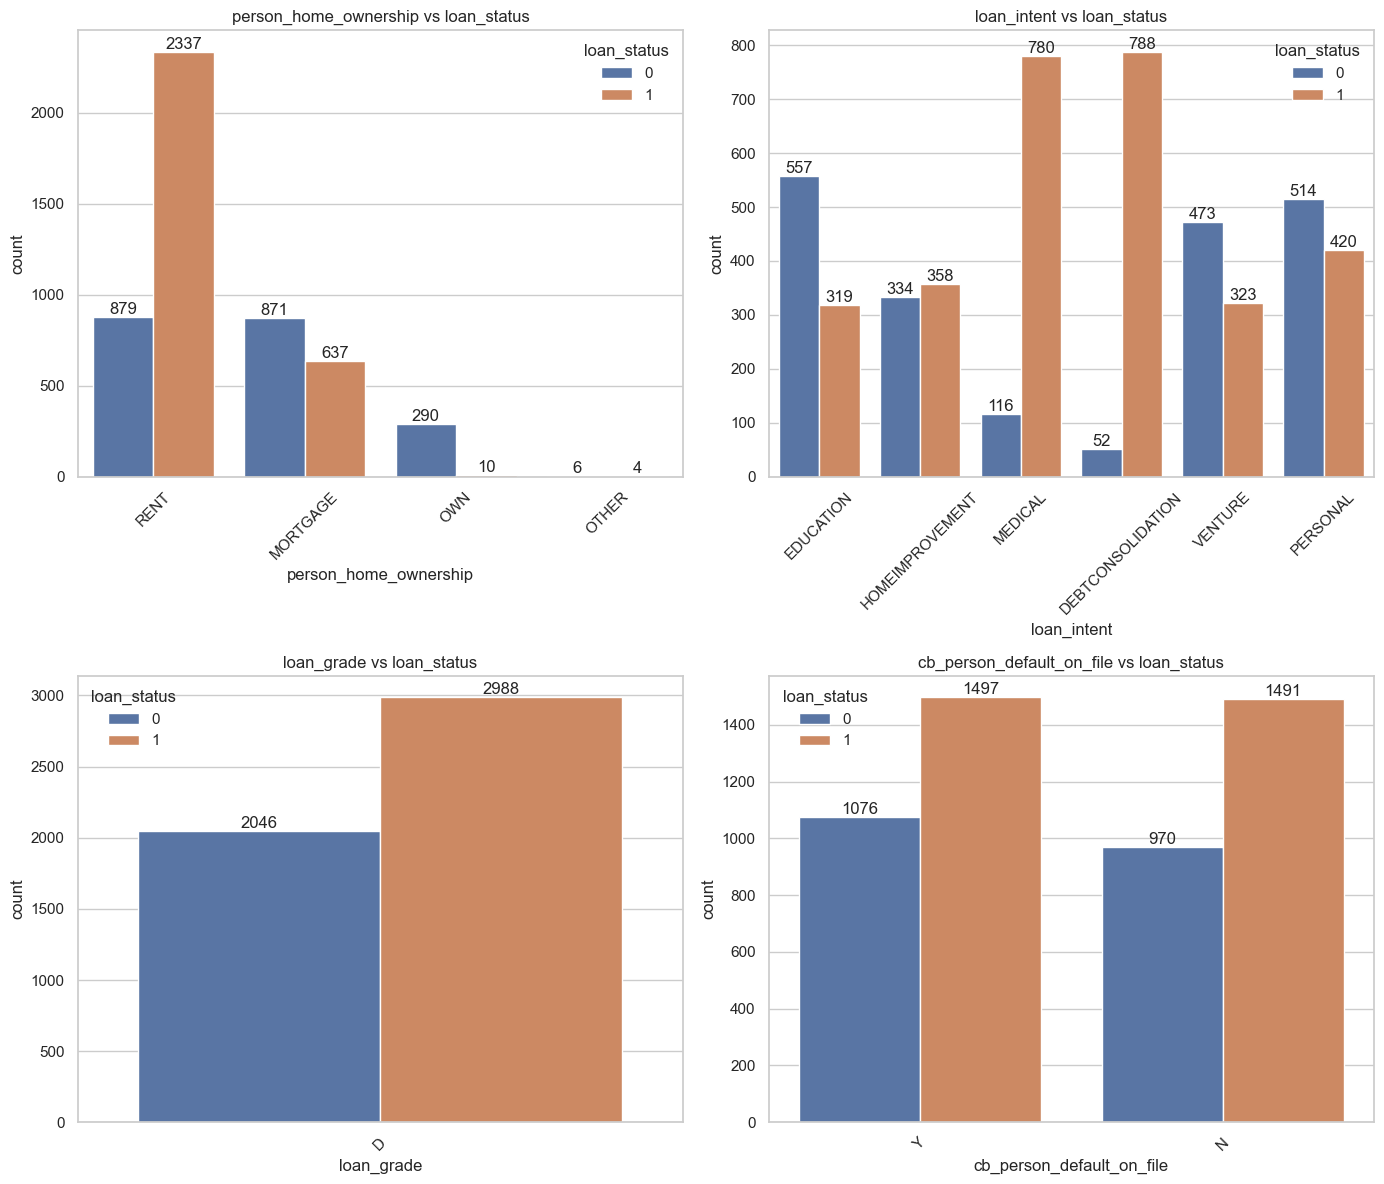




Rank: E



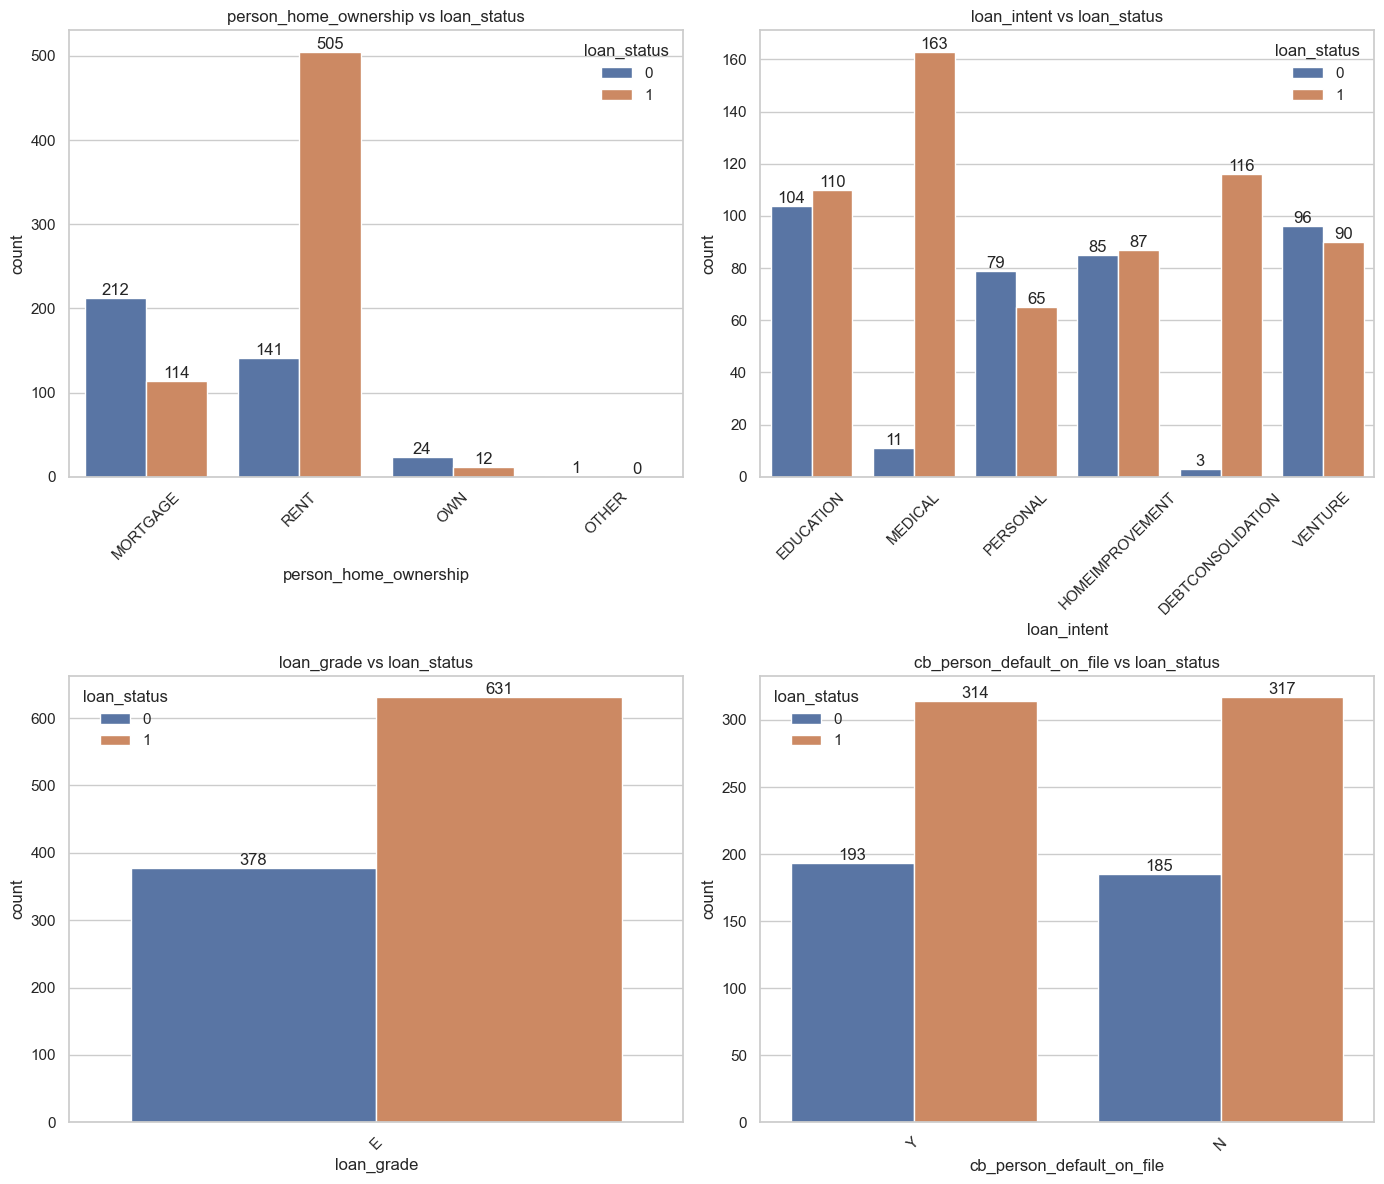




Rank: F



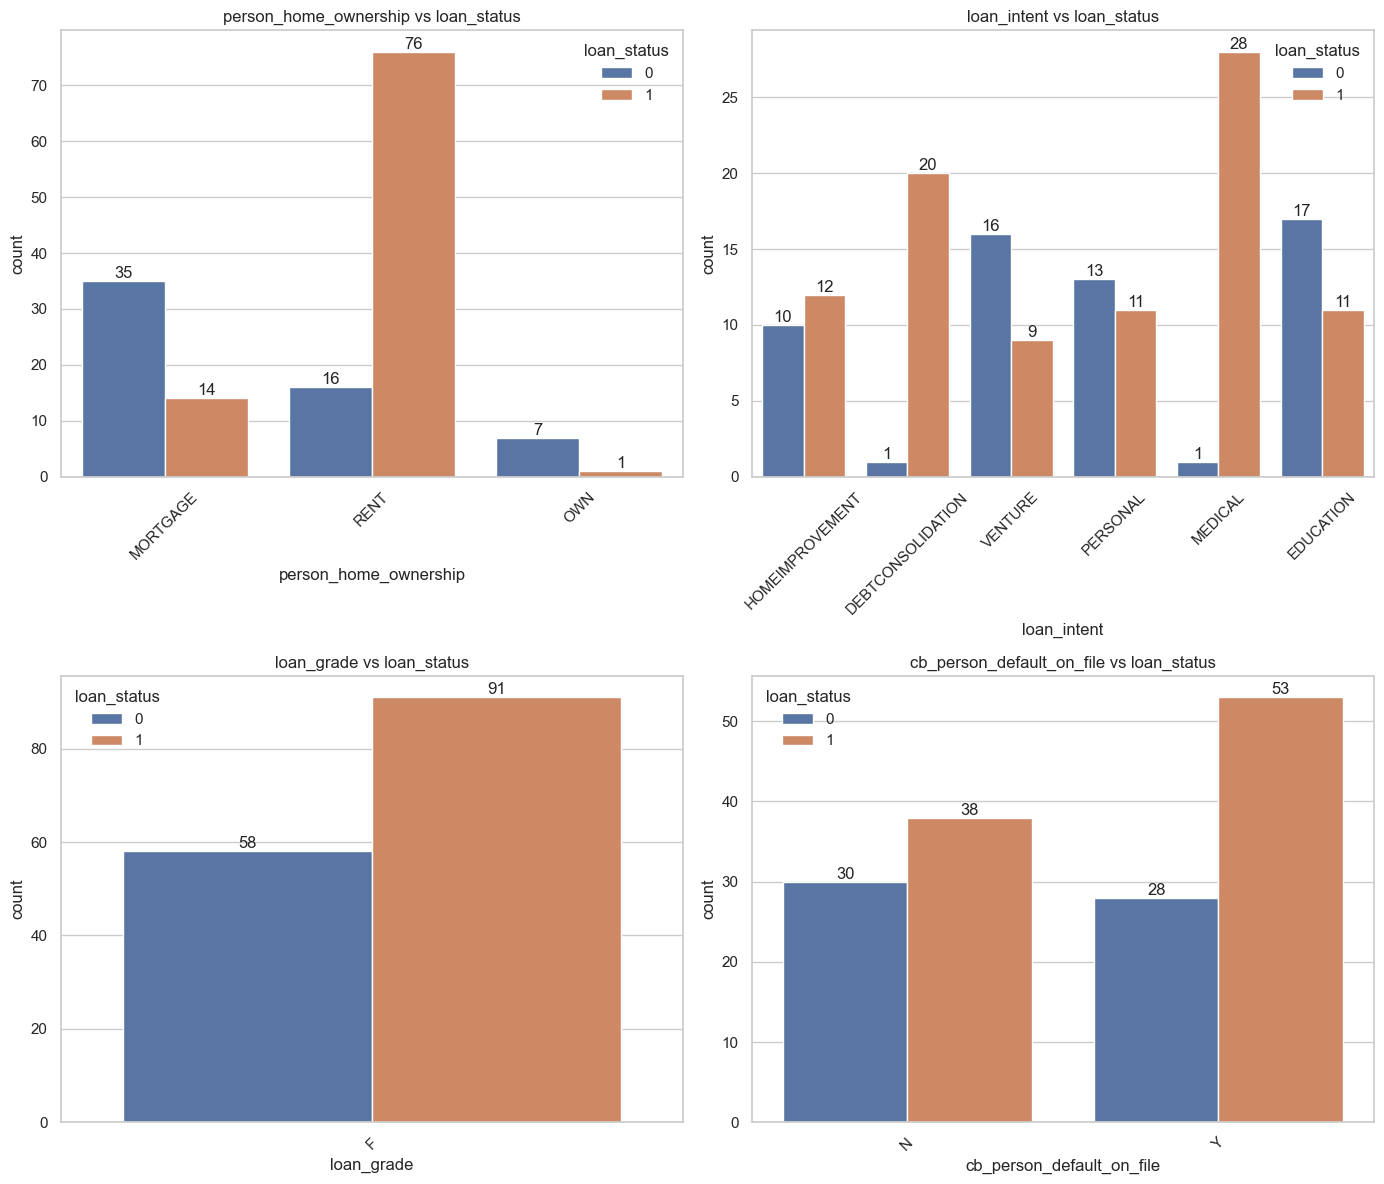




Rank: G



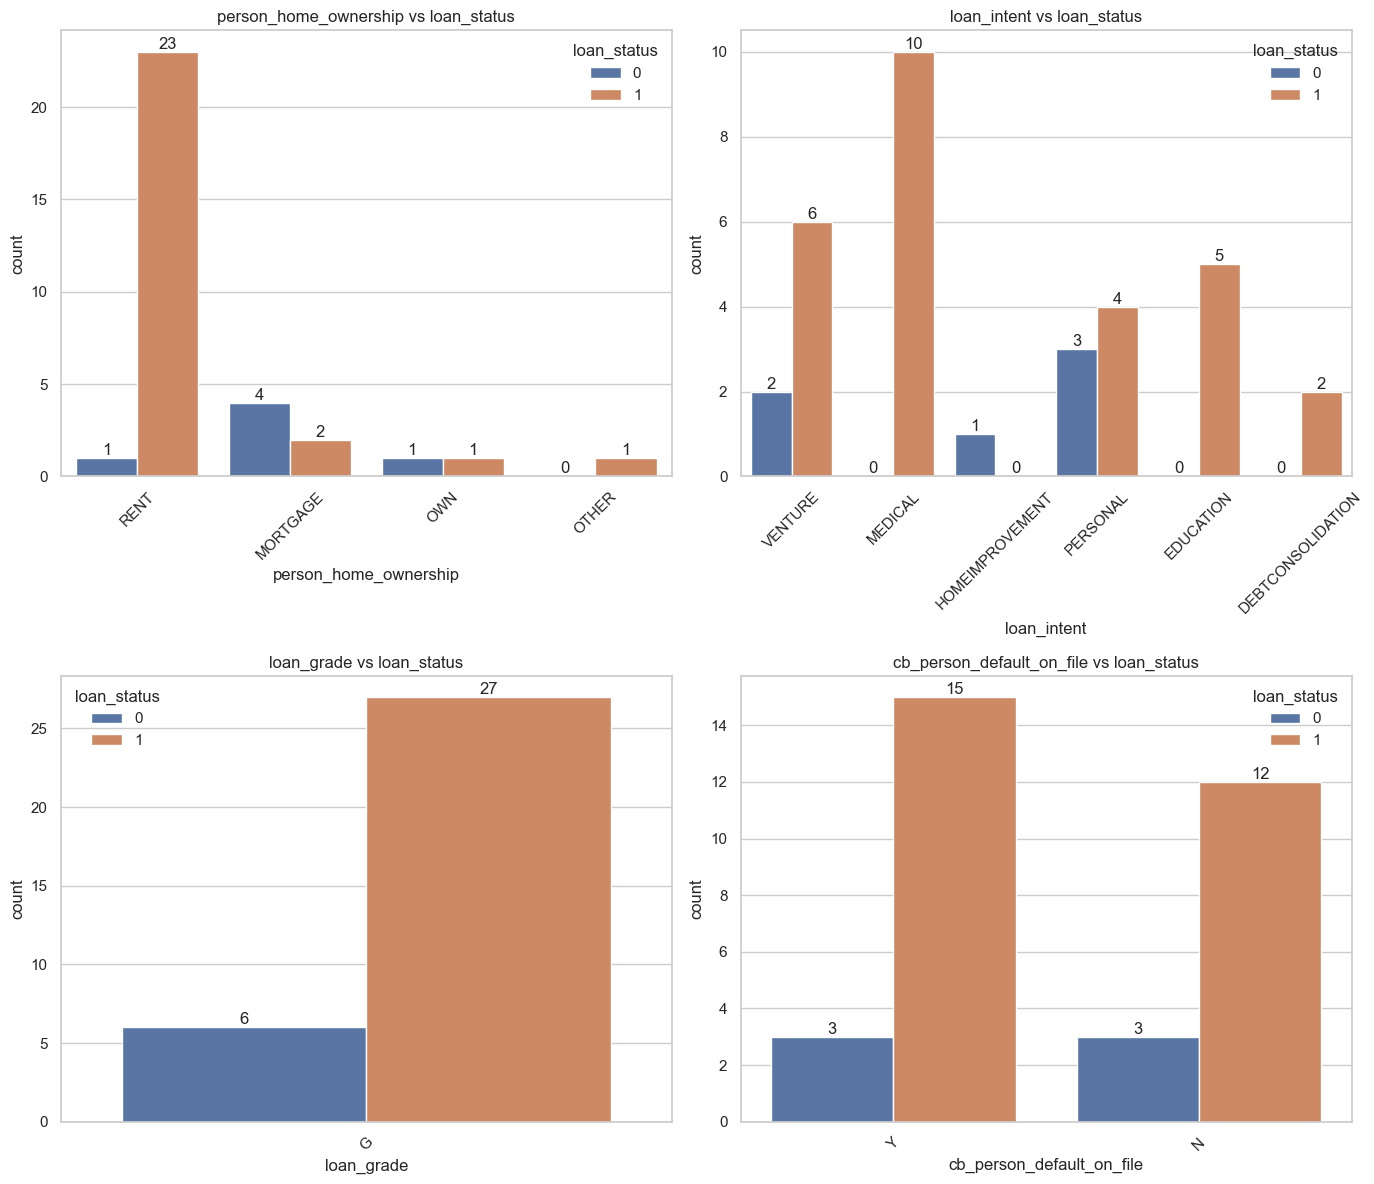

In [195]:
sns.set(style="whitegrid")
for rank in train_df['loan_grade'].unique():
    print(f'Rank: {rank}\n')
    n_cols = 2  
    n_rows = (len(object_columns) + n_cols - 1) // n_cols  # 計算行數

    # 創建繪圖區域
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6 * n_rows))

    # 迴圈遍歷每個分類欄位，生成對應的圖表
    for i, column in enumerate(object_columns):
        row = i // n_cols
        col = i % n_cols
        sns.countplot(x=column, hue=TARGET, data=train_df[train_df['loan_grade']==rank], ax=axes[row, col])
        axes[row, col].set_title(f'{column} vs {TARGET}')
        axes[row, col].tick_params(axis='x', rotation=45)

    # 如果子圖數量小於網格數，則隱藏多餘的子圖
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j // n_cols, j % n_cols])

    # 顯示數字
    for ax in axes.flat:
        for container in ax.containers:
            ax.bar_label(container)
                  
    plt.tight_layout()
    plt.show()
    print('\n\n')   

##### see continue columns' performance in not approve loan group 

In [12]:
train_df[train_df[TARGET]==1].drop(columns=['id',TARGET]).describe().round(2).T

count      mean       std      min       25%  \
person_age                  8350.0     27.53      6.34    20.00     23.00   
person_income               8350.0  48224.66  22435.67  9600.00  32000.00   
person_emp_length           8350.0      3.73      3.89     0.00      1.00   
loan_amnt                   8350.0  11197.27   6468.21  1000.00   6000.00   
loan_int_rate               8350.0     13.20      3.02     5.42     11.11   
loan_percent_income         8350.0      0.24      0.12     0.01      0.14   
cb_person_cred_hist_length  8350.0      5.78      4.19     2.00      3.00   

                                 50%       75%        max  
person_age                     26.00     30.00      80.00  
person_income               44000.00  59000.00  397800.00  
person_emp_length               3.00      6.00     123.00  
loan_amnt                   10000.00  15000.00   35000.00  
loan_int_rate                  13.79     15.58      23.22  
loan_percent_income             0.25      0.33       0.83  
cb_person_cred_hist_length      4.00      8.00      30.00

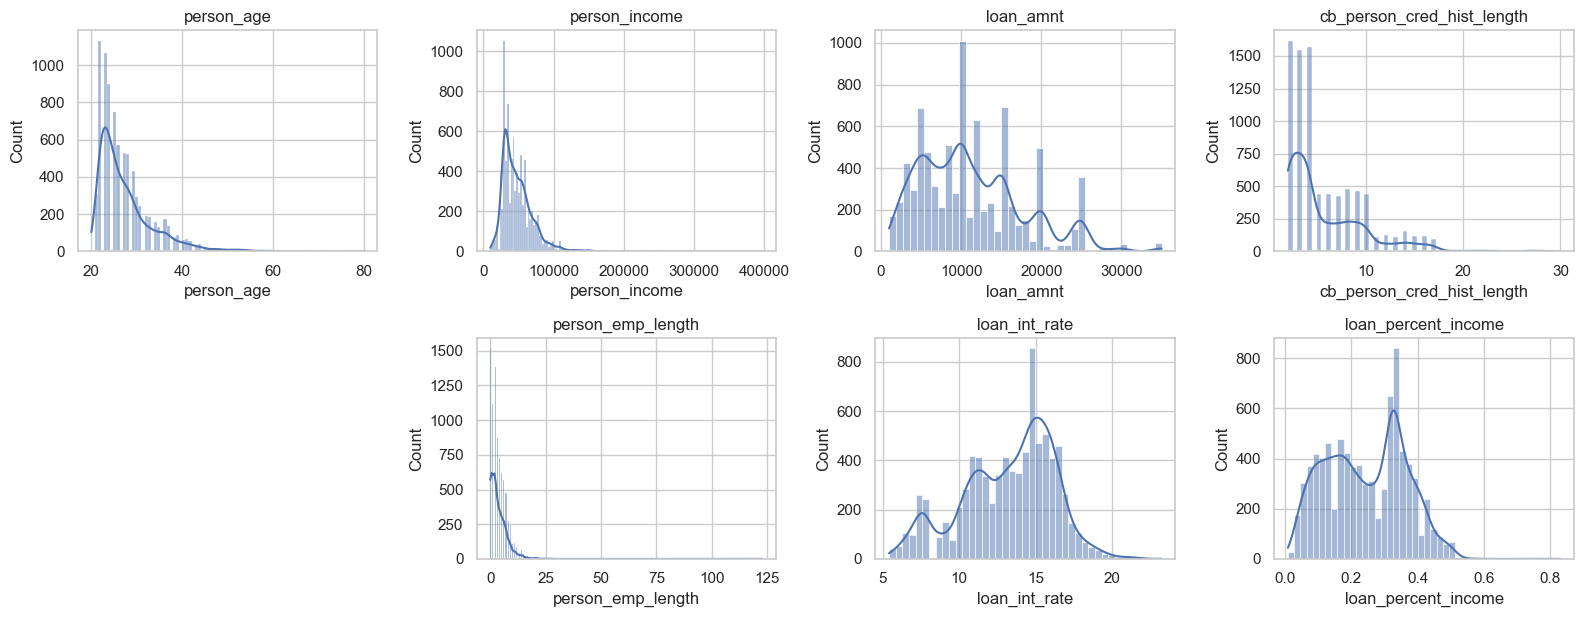

In [13]:
plt.figure(figsize=(16,12))
for count, col in enumerate(int_columns + float_columns):
    if col != TARGET:
        plt.subplot(4, 4, count + 1)
        sns.histplot(train_df[train_df[TARGET]==1][col], kde=True)
        plt.title(col)
        plt.tight_layout()

In [214]:
print('Loan_Grade：D, loan_status=1')
train_df[(train_df[TARGET]==1)&(train_df['loan_grade']=='D')].drop(columns=['id',TARGET]).describe().round(2).T

Loan_Grade：D, loan_status=1


count      mean       std      min       25%  \
person_age                  2988.0     27.56      6.56    20.00     23.00   
person_income               2988.0  51858.85  23899.00  9600.00  34000.00   
person_emp_length           2988.0      3.57      4.21     0.00      1.00   
loan_amnt                   2988.0  10313.18   6629.70  1000.00   5000.00   
loan_int_rate               2988.0     15.38      1.01     8.49     14.74   
loan_percent_income         2988.0      0.20      0.11     0.01      0.12   
cb_person_cred_hist_length  2988.0      5.78      4.34     2.00      3.00   

                                 50%       75%        max  
person_age                     25.00     30.00      80.00  
person_income               48150.00  62900.00  253000.00  
person_emp_length               2.00      5.00     123.00  
loan_amnt                    8800.00  14000.00   35000.00  
loan_int_rate                  15.32     15.99      18.25  
loan_percent_income             0.19      0.28       0.59  
cb_person_cred_hist_length      4.00      8.00      30.00

In [215]:
print('Loan_Grade：D, loan_status=0')
train_df[(train_df[TARGET]==0)&(train_df['loan_grade']=='E')].drop(columns=['id',TARGET]).describe().round(2).T

Loan_Grade：D, loan_status=0


count      mean       std       min       25%  \
person_age                  378.0     28.56      6.59     21.00     24.00   
person_income               378.0  78814.41  36007.17  12000.00  53984.25   
person_emp_length           378.0      5.74      4.17      0.00      3.00   
loan_amnt                   378.0  12685.32   6742.14   1000.00   7000.00   
loan_int_rate               378.0     16.96      1.18     13.75     16.32   
loan_percent_income         378.0      0.18      0.09      0.01      0.10   
cb_person_cred_hist_length  378.0      6.25      4.22      2.00      3.00   

                                 50%       75%        max  
person_age                     27.00     31.00      66.00  
person_income               70000.00  99963.75  250000.00  
person_emp_length               5.00      8.00      22.00  
loan_amnt                   12000.00  16000.00   35000.00  
loan_int_rate                  16.70     17.70      20.69  
loan_percent_income             0.17      0.23       0.51  
cb_person_cred_hist_length      5.00      8.00      26.00

In [216]:
print('Loan_Grade：E, loan_status=1')
train_df[(train_df[TARGET]==1)&(train_df['loan_grade']=='E')].drop(columns=['id',TARGET]).describe().round(2).T

Loan_Grade：E, loan_status=1


count      mean       std      min       25%  \
person_age                  631.0     27.64      5.77    21.00     23.00   
person_income               631.0  52351.33  21161.13  9600.00  37000.00   
person_emp_length           631.0      3.30      3.48     0.00      1.00   
loan_amnt                   631.0  11871.39   6433.39  1000.00   6000.00   
loan_int_rate               631.0     16.92      1.26     7.88     16.32   
loan_percent_income         631.0      0.23      0.11     0.02      0.14   
cb_person_cred_hist_length  631.0      5.85      4.09     2.00      3.00   

                                 50%       75%        max  
person_age                     26.00     30.00      56.00  
person_income               49000.00  62900.00  167300.00  
person_emp_length               2.00      5.00      23.00  
loan_amnt                   11000.00  16000.00   35000.00  
loan_int_rate                  16.69     17.65      23.06  
loan_percent_income             0.23      0.31       0.56  
cb_person_cred_hist_length      4.00      8.50      26.00

In [217]:
print('Loan_Grade：E, loan_status=0')
train_df[(train_df[TARGET]==0)&(train_df['loan_grade']=='E')].drop(columns=['id',TARGET]).describe().round(2).T

Loan_Grade：E, loan_status=0


count      mean       std       min       25%  \
person_age                  378.0     28.56      6.59     21.00     24.00   
person_income               378.0  78814.41  36007.17  12000.00  53984.25   
person_emp_length           378.0      5.74      4.17      0.00      3.00   
loan_amnt                   378.0  12685.32   6742.14   1000.00   7000.00   
loan_int_rate               378.0     16.96      1.18     13.75     16.32   
loan_percent_income         378.0      0.18      0.09      0.01      0.10   
cb_person_cred_hist_length  378.0      6.25      4.22      2.00      3.00   

                                 50%       75%        max  
person_age                     27.00     31.00      66.00  
person_income               70000.00  99963.75  250000.00  
person_emp_length               5.00      8.00      22.00  
loan_amnt                   12000.00  16000.00   35000.00  
loan_int_rate                  16.70     17.70      20.69  
loan_percent_income             0.17      0.23       0.51  
cb_person_cred_hist_length      5.00      8.00      26.00

In [218]:
print('Loan_Grade：F, loan_status=1')
train_df[(train_df[TARGET]==1)&(train_df['loan_grade']=='F')].drop(columns=['id',TARGET]).describe().round(2).T

Loan_Grade：F, loan_status=1


count      mean       std       min       25%  \
person_age                   91.0     28.89      8.69     21.00     23.00   
person_income                91.0  48615.48  19367.00  14400.00  33564.00   
person_emp_length            91.0      2.86      3.21      0.00      0.50   
loan_amnt                    91.0  11821.15   6670.95   1750.00   6000.00   
loan_int_rate                91.0     18.62      1.44     15.01     18.09   
loan_percent_income          91.0      0.26      0.12      0.04      0.17   
cb_person_cred_hist_length   91.0      6.40      5.14      2.00      3.00   

                                 50%       75%        max  
person_age                     25.00     32.50      58.00  
person_income               49000.00  59500.00  112000.00  
person_emp_length               2.00      4.00      17.00  
loan_amnt                   10000.00  16500.00   30000.00  
loan_int_rate                  18.43     19.13      21.74  
loan_percent_income             0.27      0.34       0.50  
cb_person_cred_hist_length      4.00      9.00      28.00

In [219]:
print('Loan_Grade：F, loan_status=0')
train_df[(train_df[TARGET]==0)&(train_df['loan_grade']=='F')].drop(columns=['id',TARGET]).describe().round(2).T

Loan_Grade：F, loan_status=0


count      mean       std       min       25%  \
person_age                   58.0     29.47      7.68     21.00     24.00   
person_income                58.0  80506.52  32230.44  25440.00  60000.00   
person_emp_length            58.0      6.93      4.10      0.00      5.00   
loan_amnt                    58.0  14422.84   7559.49   2000.00   8100.00   
loan_int_rate                58.0     18.59      1.56     15.62     17.95   
loan_percent_income          58.0      0.19      0.10      0.03      0.13   
cb_person_cred_hist_length   58.0      7.02      5.13      2.00      3.00   

                                 50%       75%        max  
person_age                     27.00     33.00      66.00  
person_income               77200.00  99000.00  192000.00  
person_emp_length               7.00      9.00      19.00  
loan_amnt                   14250.00  20600.00   30000.00  
loan_int_rate                  18.62     19.13      22.06  
loan_percent_income             0.18      0.23       0.49  
cb_person_cred_hist_length      5.50      9.00      27.00

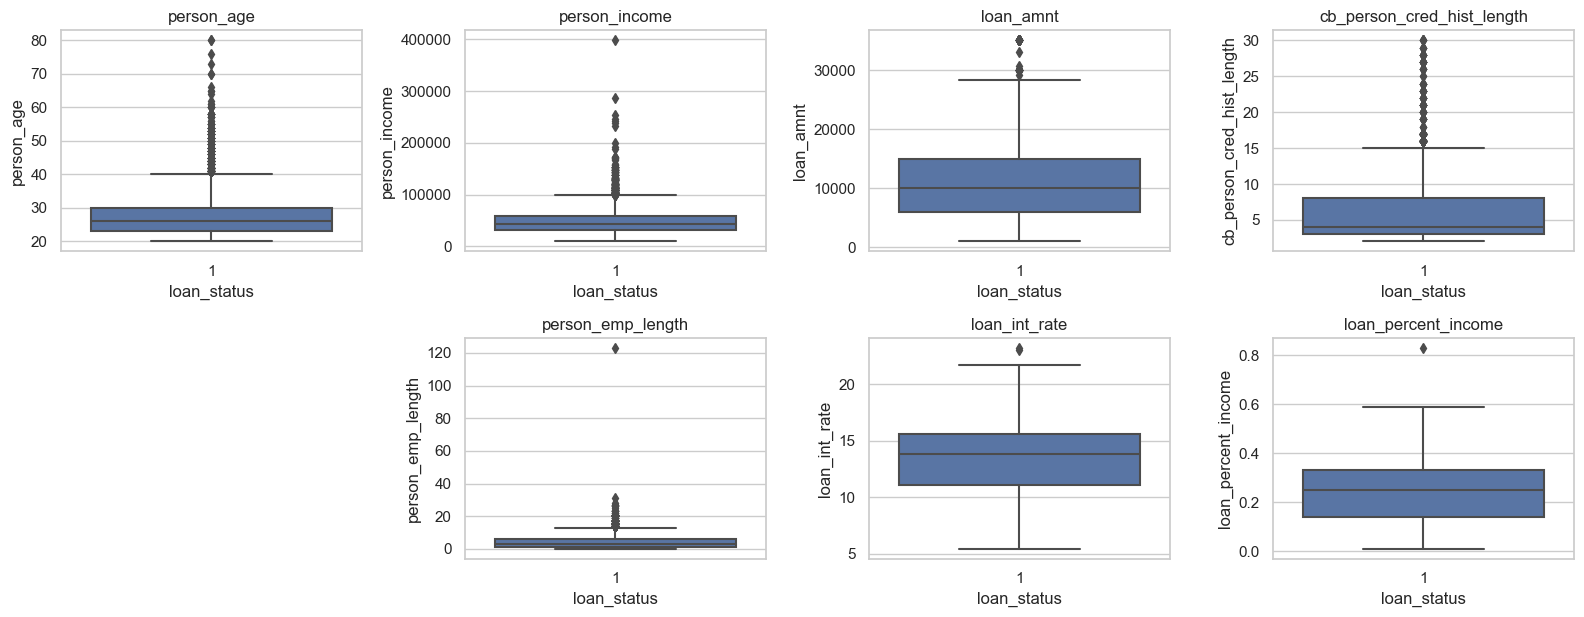

In [14]:
plt.figure(figsize=(16, 12))
for count, col in enumerate(int_columns + float_columns):
    if col != TARGET:
        plt.subplot(4, 4, count + 1)
        sns.boxplot(x=TARGET, y=col, data=train_df[train_df[TARGET]==1])
        plt.title(col)
        plt.tight_layout()

In [191]:
df_cleaned[df_cleaned['loan_status']==1]

id  person_age  person_income person_home_ownership  \
11        11          22          33000                  RENT   
24        24          22          30000                  RENT   
25        25          25          25000                  RENT   
38        38          30          54000                  RENT   
39        39          22          32000                  RENT   
...      ...         ...            ...                   ...   
58632  58632          23          29654                  RENT   
58635  58635          32          69000                  RENT   
58638  58638          29          46610              MORTGAGE   
58641  58641          28          28800                  RENT   
58642  58642          23          44000                  RENT   

       person_emp_length        loan_intent loan_grade  loan_amnt  \
11                   6.0           PERSONAL          B      10000   
24                   3.0            MEDICAL          D       5000   
25                   3.0            VENTURE          C       3500   
38                   0.0            MEDICAL          B      12500   
39                   6.0          EDUCATION          D       8000   
...                  ...                ...        ...        ...   
58632                1.0            VENTURE          A      10000   
58635                0.0  DEBTCONSOLIDATION          B      12000   
58638                1.0           PERSONAL          D       2600   
58641                0.0            MEDICAL          C      10000   
58642                7.0          EDUCATION          D       6800   

       loan_int_rate  loan_percent_income cb_person_default_on_file  \
11             11.12                 0.30                         N   
24             16.49                 0.17                         N   
25             13.49                 0.14                         Y   
38             11.71                 0.24                         N   
39             15.58                 0.25                         N   
...              ...                  ...                       ...   
58632           6.54                 0.34                         N   
58635          10.20                 0.17                         N   
58638          17.58                 0.05                         N   
58641          12.73                 0.35                         N   
58642          16.00                 0.15                         N   

       cb_person_cred_hist_length  loan_status  
11                              2            1  
24                              4            1  
25                              3            1  
38                             10            1  
39                              3            1  
...                           ...          ...  
58632                           2            1  
58635                           7            1  
58638                           6            1  
58641                           8            1  
58642                           2            1  

[6415 rows x 13 columns]

In [15]:
train_df

id  person_age  person_income person_home_ownership  \
0          0          37          35000                  RENT   
1          1          22          56000                   OWN   
2          2          29          28800                   OWN   
3          3          30          70000                  RENT   
4          4          22          60000                  RENT   
...      ...         ...            ...                   ...   
58640  58640          34         120000              MORTGAGE   
58641  58641          28          28800                  RENT   
58642  58642          23          44000                  RENT   
58643  58643          22          30000                  RENT   
58644  58644          31          75000              MORTGAGE   

       person_emp_length loan_intent loan_grade  loan_amnt  loan_int_rate  \
0                    0.0   EDUCATION          B       6000          11.49   
1                    6.0     MEDICAL          C       4000          13.35   
2                    8.0    PERSONAL          A       6000           8.90   
3                   14.0     VENTURE          B      12000          11.11   
4                    2.0     MEDICAL          A       6000           6.92   
...                  ...         ...        ...        ...            ...   
58640                5.0   EDUCATION          D      25000          15.95   
58641                0.0     MEDICAL          C      10000          12.73   
58642                7.0   EDUCATION          D       6800          16.00   
58643                2.0   EDUCATION          A       5000           8.90   
58644                2.0     VENTURE          B      15000          11.11   

       loan_percent_income cb_person_default_on_file  \
0                     0.17                         N   
1                     0.07                         N   
2                     0.21                         N   
3                     0.17                         N   
4                     0.10                         N   
...                    ...                       ...   
58640                 0.21                         Y   
58641                 0.35                         N   
58642                 0.15                         N   
58643                 0.17                         N   
58644                 0.20                         N   

       cb_person_cred_hist_length  loan_status  
0                              14            0  
1                               2            0  
2                              10            0  
3                               5            0  
4                               3            0  
...                           ...          ...  
58640                          10            0  
58641                           8            1  
58642                           2            1  
58643                           3            0  
58644                           5            0  

[58645 rows x 13 columns]

In [16]:
train_df[int_columns + float_columns]

person_age  person_income  loan_amnt  cb_person_cred_hist_length  \
0              37          35000       6000                          14   
1              22          56000       4000                           2   
2              29          28800       6000                          10   
3              30          70000      12000                           5   
4              22          60000       6000                           3   
...           ...            ...        ...                         ...   
58640          34         120000      25000                          10   
58641          28          28800      10000                           8   
58642          23          44000       6800                           2   
58643          22          30000       5000                           3   
58644          31          75000      15000                           5   

       loan_status  person_emp_length  loan_int_rate  loan_percent_income  
0                0                0.0          11.49                 0.17  
1                0                6.0          13.35                 0.07  
2                0                8.0           8.90                 0.21  
3                0               14.0          11.11                 0.17  
4                0                2.0           6.92                 0.10  
...            ...                ...            ...                  ...  
58640            0                5.0          15.95                 0.21  
58641            1                0.0          12.73                 0.35  
58642            1                7.0          16.00                 0.15  
58643            0                2.0           8.90                 0.17  
58644            0                2.0          11.11                 0.20  

[58645 rows x 8 columns]

#### Pretesting the data performance using label encoding trans the category col

In [17]:
from sklearn.preprocessing import LabelEncoder
meta_input_df = train_df.copy()

# Initialize the label encoder
label_encoder = LabelEncoder()

# Apply label encoding to each object column
for col in object_columns:
    meta_input_df[col] = label_encoder.fit_transform(meta_input_df[col])
    

In [18]:
mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
mapping


{'N': 0, 'Y': 1}

In [19]:
# Display the first few rows of the updated dataframe
meta_input_df.dtypes
meta_input_df.shape

(58645, 13)

In [351]:
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(train_df.drop(columns=['id',TARGET]+object_columns),
                                                    train_df[TARGET],
                                                    test_size=0.3, 
                                                    random_state=42)

lgbm = lgb.LGBMClassifier()
lgbm.fit(X_1_train, y_1_train)

[LightGBM] [Info] Number of positive: 5882, number of negative: 35169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1566
[LightGBM] [Info] Number of data points in the train set: 41051, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143285 -> initscore=-1.788268
[LightGBM] [Info] Start training from score -1.788268


LGBMClassifier()

In [352]:
# trian dataset
y_1_train_pred = lgbm.predict(X_1_train)
y_1_train_proba = lgbm.predict_proba(X_1_train)[:, 1]

print('Train dataset :')
print(classification_report(y_1_train, y_1_train_pred))
print('Confusion matrix :\n',
confusion_matrix(y_1_train, y_1_train_pred, labels=[0, 1]))
print('\nAccuracy :', accuracy_score(y_1_train, y_1_train_pred))
print('AUC score :', roc_auc_score(y_1_train, y_1_train_proba))
print('F1-score :', f1_score(y_1_train, y_1_train_pred))
print('Precision score :', precision_score(y_1_train, y_1_train_pred))
print('Recall score :', recall_score(y_1_train, y_1_train_pred))

# test datset
y_test_pred1 = lgbm.predict(X_1_test)
y_test_proba1 = lgbm.predict_proba(X_1_test)[:, 1]

print('\n\nTest dataset :')
print(classification_report(y_1_test, y_test_pred1))
print('Confusion matrix :\n',
confusion_matrix(y_1_test, y_test_pred1, labels=[0, 1]))
print('\nAccuracy :', accuracy_score(y_1_test, y_test_pred1))
print('AUC score :', roc_auc_score(y_1_test, y_test_pred1))
print('F1-score :', f1_score(y_1_test, y_test_pred1))
print('Precision score :', precision_score(y_1_test, y_test_pred1))
print('Recall score :', recall_score(y_1_test, y_test_pred1))

Train dataset :
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     35169
           1       0.83      0.67      0.74      5882

    accuracy                           0.93     41051
   macro avg       0.89      0.83      0.85     41051
weighted avg       0.93      0.93      0.93     41051

Confusion matrix :
 [[34376   793]
 [ 1922  3960]]

Accuracy : 0.9338627560838957
AUC score : 0.9557057248678744
F1-score : 0.7447108603667136
Precision score : 0.8331580054702293
Recall score : 0.6732403944236655


Test dataset :
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     15126
           1       0.77      0.62      0.69      2468

    accuracy                           0.92     17594
   macro avg       0.85      0.80      0.82     17594
weighted avg       0.92      0.92      0.92     17594

Confusion matrix :
 [[14656   470]
 [  928  1540]]

Accuracy : 0.9205410935546209
AUC score : 0.796

#### Preprocessing

In [22]:
print(f'int_columns：{int_columns}')
print(f'float_columns：{float_columns}')
print(f'object_columns：{object_columns}')

int_columns：['person_age', 'person_income', 'loan_amnt', 'cb_person_cred_hist_length', 'loan_status']
float_columns：['person_emp_length', 'loan_int_rate', 'loan_percent_income']
object_columns：['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


In [85]:
preprocessor = Preprocessor()
input_meta_df, mapping_df = preprocessor.preprocess(df=train_df,
                                                    one_hot_columns=['loan_grade','person_home_ownership', 'loan_intent', 'cb_person_default_on_file'])


In [86]:
input_meta_df.dtypes

id                                  int64
person_age                          int64
person_income                       int64
person_emp_length                 float64
loan_amnt                           int64
loan_int_rate                     float64
loan_percent_income               float64
cb_person_cred_hist_length          int64
loan_status                         int64
loan_grade_A                      float64
loan_grade_B                      float64
loan_grade_C                      float64
loan_grade_D                      float64
loan_grade_E                      float64
loan_grade_F                      float64
loan_grade_G                      float64
person_home_ownership_MORTGAGE    float64
person_home_ownership_OTHER       float64
person_home_ownership_OWN         float64
person_home_ownership_RENT        float64
loan_intent_DEBTCONSOLIDATION     float64
loan_intent_EDUCATION             float64
loan_intent_HOMEIMPROVEMENT       float64
loan_intent_MEDICAL               

In [87]:
# preprocessor = Preprocessor()
# meta_data_df, mapping_table_df = preprocessor.preprocess(train_df, one_hot_columns=)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(input_meta_df.drop(columns=['id',TARGET]), input_meta_df[TARGET], test_size=0.3, random_state=42)

lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train)

# trian dataset
y_train_pred = lgbm.predict(X_train)
y_train_proba = lgbm.predict_proba(X_train)[:, 1]

print('Train dataset :')
print(classification_report(y_train, y_train_pred))
print('Confusion matrix :\n',
confusion_matrix(y_train, y_train_pred, labels=[0, 1]))
print('\nAccuracy :', accuracy_score(y_train, y_train_pred))
print('AUC score :', roc_auc_score(y_train, y_train_proba))
print('F1-score :', f1_score(y_train, y_train_pred))
print('Precision score :', precision_score(y_train, y_train_pred))
print('Recall score :', recall_score(y_train, y_train_pred))

# test datset
y_test_pred = lgbm.predict(X_test)
y_test_proba = lgbm.predict_proba(X_test)[:, 1]

print('\n\nTest dataset :')
print(classification_report(y_test, y_test_pred))
print('Confusion matrix :\n',
confusion_matrix(y_test, y_test_pred, labels=[0, 1]))
print('\nAccuracy :', accuracy_score(y_test, y_test_pred))
print('AUC score :', roc_auc_score(y_test, y_test_proba))
print('F1-score :', f1_score(y_test, y_test_pred))
print('Precision score :', precision_score(y_test, y_test_pred))
print('Recall score :', recall_score(y_test, y_test_pred))

[LightGBM] [Info] Number of positive: 5882, number of negative: 35169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 41051, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143285 -> initscore=-1.788268
[LightGBM] [Info] Start training from score -1.788268
Train dataset :
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     35169
           1       0.94      0.74      0.83      5882

    accuracy                           0.96     41051
   macro avg       0.95      0.87      0.90     41051
weighted avg       0.96      0.96      0.95     41051

Confusion matrix :
 [[34915   254]
 [ 1537  4345]]

Accuracy : 0.9563713429636306
AUC score : 0.9770926034913228
F1-score : 0.8291193588398054
Precision score : 0.94

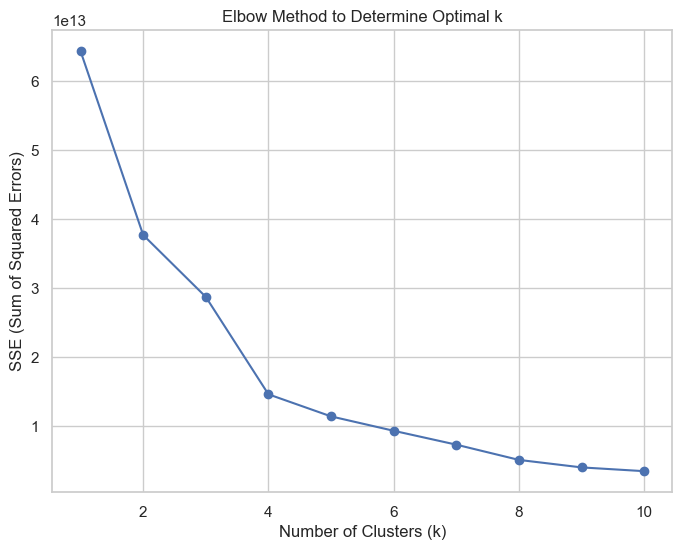

In [89]:
from sklearn.cluster import KMeans


# 儲存每個 k 對應的 SSE (Sum of Squared Errors)
sse = []

# k 值範圍
K = range(1, 11)  # 假設我們從 1 到 10 測試

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train)
    sse.append(kmeans.inertia_)  # inertia 是 SSE 的另一種表示方式

# 繪製 SSE 與 k 的關係
plt.figure(figsize=(8, 6))
plt.plot(K, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('Elbow Method to Determine Optimal k')
plt.grid(True)
plt.show()


In [90]:
# Create cross features
input_meta_df['age_income'] = input_meta_df['person_age'] * input_meta_df['person_income']
input_meta_df['loan_amnt_age'] = input_meta_df['loan_amnt'] / input_meta_df['person_age']

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)  # 假设我们分成3个群
input_meta_df['cluster'] = kmeans.fit_predict(input_meta_df.drop(columns=['id', TARGET]))

# Display the first few rows of the updated dataframe
input_meta_df.head()

id  person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
0   0          37          35000                0.0       6000          11.49   
1   1          22          56000                6.0       4000          13.35   
2   2          29          28800                8.0       6000           8.90   
3   3          30          70000               14.0      12000          11.11   
4   4          22          60000                2.0       6000           6.92   

   loan_percent_income  cb_person_cred_hist_length  loan_status  loan_grade_A  \
0                 0.17                          14            0           0.0   
1                 0.07                           2            0           0.0   
2                 0.21                          10            0           1.0   
3                 0.17                           5            0           0.0   
4                 0.10                           3            0           1.0   

   ...  loan_intent_EDUCATION  loan_intent_HOMEIMPROVEMENT  \
0  ...                    1.0                          0.0   
1  ...                    0.0                          0.0   
2  ...                    0.0                          0.0   
3  ...                    0.0                          0.0   
4  ...                    0.0                          0.0   

   loan_intent_MEDICAL  loan_intent_PERSONAL  loan_intent_VENTURE  \
0                  0.0                   0.0                  0.0   
1                  1.0                   0.0                  0.0   
2                  0.0                   1.0                  0.0   
3                  0.0                   0.0                  1.0   
4                  1.0                   0.0                  0.0   

   cb_person_default_on_file_N  cb_person_default_on_file_Y  age_income  \
0                          1.0                          0.0     1295000   
1                          1.0                          0.0     1232000   
2                          1.0                          0.0      835200   
3                          1.0                          0.0     2100000   
4                          1.0                          0.0     1320000   

   loan_amnt_age  cluster  
0     162.162162        2  
1     181.818182        2  
2     206.896552        2  
3     400.000000        0  
4     272.727273        2  

[5 rows x 31 columns]

In [91]:
X_train, X_test, y_train, y_test = train_test_split(input_meta_df.drop(columns=['id',
                                                                                'loan_grade_A',
                                                                                'loan_grade_E',
                                                                                'loan_grade_F',
                                                                                'loan_grade_G',
                                                                                TARGET]),
                                                    input_meta_df[TARGET],
                                                    test_size=0.3,
                                                    random_state=42)



In [92]:
X_train, X_test, y_train, y_test = train_test_split(input_meta_df.drop(columns=['id',TARGET]),
                                                    input_meta_df[TARGET],
                                                    test_size=0.3,
                                                    random_state=42)

In [94]:
import numpy as np
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import logging
import warnings

# 忽略不必要的警告
warnings.filterwarnings('ignore')

# 配置日誌
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


# 或者使用交叉驗證

def objective(params):
    try:
        # 將某些參數轉換為整數
        params['num_leaves'] = int(params['num_leaves'])
        params['n_estimators'] = int(params['n_estimators'])
        params['min_child_samples'] = int(params['min_child_samples'])
        
        max_depth = params['max_depth']
        num_leaves = params['num_leaves']
        
        # 檢查 num_leaves 是否合理
        if num_leaves > (2 ** max_depth):
            logger.warning(f'num_leaves {num_leaves} > 2^max_depth {2 ** max_depth}. 調整 num_leaves 為 2^max_depth.')
            params['num_leaves'] = 2 ** max_depth
        
        # 初始化 LightGBM 分類器
        model = lgb.LGBMClassifier(
            num_leaves=params['num_leaves'],
            max_depth=params['max_depth'],
            learning_rate=params['learning_rate'],
            n_estimators=params['n_estimators'],
            min_child_samples=params['min_child_samples'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            reg_alpha=params['reg_alpha'],
            reg_lambda=params['reg_lambda'],
            random_state=42,
            n_jobs=-1
        )
        
        # 使用交叉驗證評估模型性能
        # 這裡使用 5 折交叉驗證，您可以根據需要調整
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
        auc = scores.mean()
        
        # 記錄當前參數和 AUC
        logger.info(f"Params: {params}, AUC: {auc}")
        
        # 目標是最大化 AUC，因此返回負的 AUC
        return {'loss': -auc, 'status': STATUS_OK}
    
    except FloatingPointError as e:
        logger.error(f"FloatingPointError encountered: {e} with params: {params}")
        return {'loss': float('inf'), 'status': STATUS_FAIL}
    except Exception as e:
        logger.error(f"Exception {e} encountered with params: {params}")
        return {'loss': float('inf'), 'status': STATUS_FAIL}

# 定義搜索空間
space = {
    'num_leaves': hp.quniform('num_leaves', 20, 70, 10),          # 20, 30, 40, 50, 60, 70
    'max_depth': hp.choice('max_depth', list(range(5, 20))),    # 5 到 19
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),  # 100 到 1000，步長為 50
    'min_child_samples': hp.choice('min_child_samples', list(range(20, 31))),  # 20 到 30
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'imbalanced': True
}

# 儲存試驗結果
trials = Trials()

# 使用 TPE 進行超參數調整
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=30,
    trials=trials,
    rstate=np.random.default_rng(42)  # 設定隨機種子以確保結果可重現
)

print("最佳參數:", best)


  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

2024-10-13 01:52:33,489 - INFO - build_posterior_wrapper took 0.003009 seconds
2024-10-13 01:52:33,490 - INFO - TPE using 0 trials
2024-10-13 01:52:39,788 - INFO - Params: {'colsample_bytree': 0.6619995178577169, 'imbalanced': True, 'learning_rate': 0.1140162121990579, 'max_depth': 6, 'min_child_samples': 30, 'n_estimators': 800, 'num_leaves': 50, 'reg_alpha': 0.8839266254726155, 'reg_lambda': 0.620118997676641, 'subsample': 0.9068277038201439}, AUC: 0.9499458876932945


  3%|▎         | 1/30 [00:06<03:02,  6.30s/trial, best loss: -0.9499458876932945]

2024-10-13 01:52:39,793 - INFO - build_posterior_wrapper took 0.003136 seconds
2024-10-13 01:52:39,794 - INFO - TPE using 1/1 trials with best loss -0.949946
2024-10-13 01:52:42,549 - INFO - Params: {'colsample_bytree': 0.5027440166274143, 'imbalanced': True, 'learning_rate': 0.20280467961378887, 'max_depth': 6, 'min_child_samples': 29, 'n_estimators': 600, 'num_leaves': 20, 'reg_alpha': 0.8609304819134347, 'reg_lambda': 0.6082491621711366, 'subsample': 0.6502106773952542}, AUC: 0.9518154796123215


  7%|▋         | 2/30 [00:09<01:58,  4.22s/trial, best loss: -0.9518154796123215]

2024-10-13 01:52:42,554 - INFO - build_posterior_wrapper took 0.002990 seconds
2024-10-13 01:52:42,555 - INFO - TPE using 2/2 trials with best loss -0.951815
2024-10-13 01:52:46,331 - INFO - Params: {'colsample_bytree': 0.7628467068329106, 'imbalanced': True, 'learning_rate': 0.20717412460561102, 'max_depth': 17, 'min_child_samples': 27, 'n_estimators': 600, 'num_leaves': 30, 'reg_alpha': 0.6176608512730031, 'reg_lambda': 0.07366102545052411, 'subsample': 0.5734813936425138}, AUC: 0.948899545191856


 10%|█         | 3/30 [00:12<01:48,  4.02s/trial, best loss: -0.9518154796123215]

2024-10-13 01:52:46,335 - INFO - build_posterior_wrapper took 0.002986 seconds
2024-10-13 01:52:46,336 - INFO - TPE using 3/3 trials with best loss -0.951815
2024-10-13 01:52:48,615 - INFO - Params: {'colsample_bytree': 0.791765801223419, 'imbalanced': True, 'learning_rate': 0.020146521712146016, 'max_depth': 12, 'min_child_samples': 30, 'n_estimators': 150, 'num_leaves': 60, 'reg_alpha': 0.5924534133258075, 'reg_lambda': 0.21221711699333523, 'subsample': 0.7018888351309895}, AUC: 0.9470481676092664


 13%|█▎        | 4/30 [00:15<01:26,  3.33s/trial, best loss: -0.9518154796123215]

2024-10-13 01:52:48,620 - INFO - build_posterior_wrapper took 0.002938 seconds
2024-10-13 01:52:48,620 - INFO - TPE using 4/4 trials with best loss -0.951815
2024-10-13 01:52:52,584 - INFO - Params: {'colsample_bytree': 0.8807865384983995, 'imbalanced': True, 'learning_rate': 0.055217293267309744, 'max_depth': 11, 'min_child_samples': 27, 'n_estimators': 400, 'num_leaves': 40, 'reg_alpha': 0.28735631985323384, 'reg_lambda': 0.09664464567700914, 'subsample': 0.7514518773307409}, AUC: 0.9545257415918403


 17%|█▋        | 5/30 [00:19<01:29,  3.56s/trial, best loss: -0.9545257415918403]

2024-10-13 01:52:52,588 - INFO - build_posterior_wrapper took 0.003013 seconds
2024-10-13 01:52:52,589 - INFO - TPE using 5/5 trials with best loss -0.954526
2024-10-13 01:53:02,353 - INFO - Params: {'colsample_bytree': 0.9250198863250396, 'imbalanced': True, 'learning_rate': 0.048038998810205125, 'max_depth': 13, 'min_child_samples': 28, 'n_estimators': 900, 'num_leaves': 60, 'reg_alpha': 0.44194339835245333, 'reg_lambda': 0.16102410861748417, 'subsample': 0.8773636801323945}, AUC: 0.9504739222537312


 20%|██        | 6/30 [00:28<02:16,  5.67s/trial, best loss: -0.9545257415918403]

2024-10-13 01:53:02,358 - INFO - build_posterior_wrapper took 0.002999 seconds
2024-10-13 01:53:02,359 - INFO - TPE using 6/6 trials with best loss -0.954526
2024-10-13 01:53:08,915 - INFO - Params: {'colsample_bytree': 0.5666078601132389, 'imbalanced': True, 'learning_rate': 0.016962081226913076, 'max_depth': 19, 'min_child_samples': 27, 'n_estimators': 550, 'num_leaves': 60, 'reg_alpha': 0.08174694195215582, 'reg_lambda': 0.9969872099001056, 'subsample': 0.8495392973707541}, AUC: 0.9555772106236521


 23%|██▎       | 7/30 [00:35<02:17,  5.96s/trial, best loss: -0.9555772106236521]

2024-10-13 01:53:08,920 - INFO - build_posterior_wrapper took 0.003009 seconds
2024-10-13 01:53:08,921 - INFO - TPE using 7/7 trials with best loss -0.955577
2024-10-13 01:53:11,346 - INFO - Params: {'colsample_bytree': 0.6669925735866169, 'imbalanced': True, 'learning_rate': 0.11914558625685459, 'max_depth': 16, 'min_child_samples': 27, 'n_estimators': 250, 'num_leaves': 40, 'reg_alpha': 0.7480357729604008, 'reg_lambda': 0.8300896323724805, 'subsample': 0.5321434316547746}, AUC: 0.953998347964189


 27%|██▋       | 8/30 [00:37<01:46,  4.84s/trial, best loss: -0.9555772106236521]

2024-10-13 01:53:11,351 - INFO - build_posterior_wrapper took 0.002014 seconds
2024-10-13 01:53:11,352 - INFO - TPE using 8/8 trials with best loss -0.955577
2024-10-13 01:53:20,142 - INFO - Params: {'colsample_bytree': 0.922980000436168, 'imbalanced': True, 'learning_rate': 0.03305486342407529, 'max_depth': 10, 'min_child_samples': 26, 'n_estimators': 1000, 'num_leaves': 50, 'reg_alpha': 0.05407787444418399, 'reg_lambda': 0.7713808175958373, 'subsample': 0.8616492018371803}, AUC: 0.9523481030987044


 30%|███       | 9/30 [00:46<02:07,  6.08s/trial, best loss: -0.9555772106236521]

2024-10-13 01:53:20,147 - INFO - build_posterior_wrapper took 0.003004 seconds
2024-10-13 01:53:20,148 - INFO - TPE using 9/9 trials with best loss -0.955577
2024-10-13 01:53:27,527 - INFO - Params: {'colsample_bytree': 0.5435168750203994, 'imbalanced': True, 'learning_rate': 0.023041939736678133, 'max_depth': 15, 'min_child_samples': 30, 'n_estimators': 700, 'num_leaves': 60, 'reg_alpha': 0.4349979536508063, 'reg_lambda': 0.4805571687112412, 'subsample': 0.6625161963677373}, AUC: 0.9557388696534461


 33%|███▎      | 10/30 [00:54<02:09,  6.48s/trial, best loss: -0.9557388696534461]

2024-10-13 01:53:27,531 - INFO - build_posterior_wrapper took 0.002994 seconds
2024-10-13 01:53:27,532 - INFO - TPE using 10/10 trials with best loss -0.955739
2024-10-13 01:53:37,660 - INFO - Params: {'colsample_bytree': 0.6730540999927901, 'imbalanced': True, 'learning_rate': 0.18486235100672668, 'max_depth': 13, 'min_child_samples': 29, 'n_estimators': 950, 'num_leaves': 70, 'reg_alpha': 0.26832475371053754, 'reg_lambda': 0.041260357370912715, 'subsample': 0.51735171792841}, AUC: 0.945605942017442


 37%|███▋      | 11/30 [01:04<02:24,  7.60s/trial, best loss: -0.9557388696534461]

2024-10-13 01:53:37,664 - INFO - build_posterior_wrapper took 0.002999 seconds
2024-10-13 01:53:37,665 - INFO - TPE using 11/11 trials with best loss -0.955739
2024-10-13 01:53:40,564 - INFO - Params: {'colsample_bytree': 0.9597370637408449, 'imbalanced': True, 'learning_rate': 0.08207964666880692, 'max_depth': 19, 'min_child_samples': 22, 'n_estimators': 350, 'num_leaves': 40, 'reg_alpha': 0.10483061704646857, 'reg_lambda': 0.6081523849100594, 'subsample': 0.8905439168319457}, AUC: 0.9529895362765763


 40%|████      | 12/30 [01:07<01:51,  6.17s/trial, best loss: -0.9557388696534461]

2024-10-13 01:53:40,569 - INFO - build_posterior_wrapper took 0.002997 seconds
2024-10-13 01:53:40,570 - INFO - TPE using 12/12 trials with best loss -0.955739
2024-10-13 01:53:45,915 - INFO - Params: {'colsample_bytree': 0.5986117604297474, 'imbalanced': True, 'learning_rate': 0.05880819270388856, 'max_depth': 14, 'min_child_samples': 28, 'n_estimators': 850, 'num_leaves': 30, 'reg_alpha': 0.6091041490883193, 'reg_lambda': 0.730039600362054, 'subsample': 0.6415804690150524}, AUC: 0.9544739621880668


 43%|████▎     | 13/30 [01:12<01:40,  5.92s/trial, best loss: -0.9557388696534461]

2024-10-13 01:53:45,920 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-10-13 01:53:45,920 - INFO - TPE using 13/13 trials with best loss -0.955739
2024-10-13 01:53:53,334 - INFO - Params: {'colsample_bytree': 0.8419617420246999, 'imbalanced': True, 'learning_rate': 0.07008783953191133, 'max_depth': 7, 'min_child_samples': 22, 'n_estimators': 800, 'num_leaves': 60, 'reg_alpha': 0.08885184806583746, 'reg_lambda': 0.4671485658354062, 'subsample': 0.5337114618970547}, AUC: 0.9500454609670592


 47%|████▋     | 14/30 [01:19<01:41,  6.37s/trial, best loss: -0.9557388696534461]

2024-10-13 01:53:53,339 - INFO - build_posterior_wrapper took 0.003010 seconds
2024-10-13 01:53:53,339 - INFO - TPE using 14/14 trials with best loss -0.955739
2024-10-13 01:53:55,839 - INFO - Params: {'colsample_bytree': 0.706204310091011, 'imbalanced': True, 'learning_rate': 0.07466362464370122, 'max_depth': 8, 'min_child_samples': 29, 'n_estimators': 200, 'num_leaves': 70, 'reg_alpha': 0.017096689947744492, 'reg_lambda': 0.9057316356341925, 'subsample': 0.6162303187347985}, AUC: 0.9537395138518672


 50%|█████     | 15/30 [01:22<01:18,  5.21s/trial, best loss: -0.9557388696534461]

2024-10-13 01:53:55,844 - INFO - build_posterior_wrapper took 0.003015 seconds
2024-10-13 01:53:55,845 - INFO - TPE using 15/15 trials with best loss -0.955739
2024-10-13 01:54:01,892 - INFO - Params: {'colsample_bytree': 0.9662257468365374, 'imbalanced': True, 'learning_rate': 0.0810906313538436, 'max_depth': 6, 'min_child_samples': 25, 'n_estimators': 850, 'num_leaves': 40, 'reg_alpha': 0.2042842520101622, 'reg_lambda': 0.9877372119600353, 'subsample': 0.9376238045745737}, AUC: 0.9513155089127705


 53%|█████▎    | 16/30 [01:28<01:16,  5.46s/trial, best loss: -0.9557388696534461]

2024-10-13 01:54:01,896 - INFO - build_posterior_wrapper took 0.002013 seconds
2024-10-13 01:54:01,897 - INFO - TPE using 16/16 trials with best loss -0.955739
2024-10-13 01:54:05,528 - INFO - Params: {'colsample_bytree': 0.6625682567562243, 'imbalanced': True, 'learning_rate': 0.010313645639351431, 'max_depth': 10, 'min_child_samples': 28, 'n_estimators': 400, 'num_leaves': 40, 'reg_alpha': 0.816994764213365, 'reg_lambda': 0.8140834674473612, 'subsample': 0.9411338024873159}, AUC: 0.9486617170292517


 57%|█████▋    | 17/30 [01:32<01:03,  4.91s/trial, best loss: -0.9557388696534461]

2024-10-13 01:54:05,533 - INFO - build_posterior_wrapper took 0.002007 seconds
2024-10-13 01:54:05,534 - INFO - TPE using 17/17 trials with best loss -0.955739
2024-10-13 01:54:08,341 - INFO - Params: {'colsample_bytree': 0.539010295434188, 'imbalanced': True, 'learning_rate': 0.022204065034571483, 'max_depth': 7, 'min_child_samples': 26, 'n_estimators': 250, 'num_leaves': 70, 'reg_alpha': 0.3506832932733329, 'reg_lambda': 0.10308206613656157, 'subsample': 0.6624745156815548}, AUC: 0.9490659964100697


 60%|██████    | 18/30 [01:34<00:51,  4.28s/trial, best loss: -0.9557388696534461]

2024-10-13 01:54:08,345 - INFO - build_posterior_wrapper took 0.002998 seconds
2024-10-13 01:54:08,346 - INFO - TPE using 18/18 trials with best loss -0.955739
2024-10-13 01:54:12,075 - INFO - Params: {'colsample_bytree': 0.959337957982663, 'imbalanced': True, 'learning_rate': 0.10242234129746727, 'max_depth': 14, 'min_child_samples': 21, 'n_estimators': 400, 'num_leaves': 40, 'reg_alpha': 0.12807689592637184, 'reg_lambda': 0.84985492638987, 'subsample': 0.6226067744404331}, AUC: 0.9519236925805525


 63%|██████▎   | 19/30 [01:38<00:45,  4.12s/trial, best loss: -0.9557388696534461]

2024-10-13 01:54:12,080 - INFO - build_posterior_wrapper took 0.003003 seconds
2024-10-13 01:54:12,080 - INFO - TPE using 19/19 trials with best loss -0.955739
2024-10-13 01:54:14,649 - INFO - Params: {'colsample_bytree': 0.633534769152053, 'imbalanced': True, 'learning_rate': 0.1433153457183863, 'max_depth': 13, 'min_child_samples': 27, 'n_estimators': 350, 'num_leaves': 30, 'reg_alpha': 0.9759998977389169, 'reg_lambda': 0.7130445215144277, 'subsample': 0.7236617974934909}, AUC: 0.9530770453900329


 67%|██████▋   | 20/30 [01:41<00:36,  3.65s/trial, best loss: -0.9557388696534461]

2024-10-13 01:54:14,653 - INFO - build_posterior_wrapper took 0.001993 seconds
2024-10-13 01:54:14,654 - INFO - TPE using 20/20 trials with best loss -0.955739
2024-10-13 01:54:22,654 - INFO - Params: {'colsample_bytree': 0.5731943956531089, 'imbalanced': True, 'learning_rate': 0.0128847958735258, 'max_depth': 15, 'min_child_samples': 20, 'n_estimators': 700, 'num_leaves': 60, 'reg_alpha': 0.36720079101343484, 'reg_lambda': 0.3407529993008559, 'subsample': 0.7941142785966878}, AUC: 0.9552221716579743


 70%|███████   | 21/30 [01:49<00:44,  4.96s/trial, best loss: -0.9557388696534461]

2024-10-13 01:54:22,658 - INFO - build_posterior_wrapper took 0.002011 seconds
2024-10-13 01:54:22,660 - INFO - TPE using 21/21 trials with best loss -0.955739
2024-10-13 01:54:27,752 - INFO - Params: {'colsample_bytree': 0.5185650372695982, 'imbalanced': True, 'learning_rate': 0.0161839368249666, 'max_depth': 15, 'min_child_samples': 23, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 0.5016778909923744, 'reg_lambda': 0.41167145602884225, 'subsample': 0.813062523180086}, AUC: 0.954915448307759


 73%|███████▎  | 22/30 [01:54<00:40,  5.00s/trial, best loss: -0.9557388696534461]

2024-10-13 01:54:27,757 - INFO - build_posterior_wrapper took 0.003169 seconds
2024-10-13 01:54:27,757 - INFO - TPE using 22/22 trials with best loss -0.955739
2024-10-13 01:54:34,908 - INFO - Params: {'colsample_bytree': 0.5670954070648312, 'imbalanced': True, 'learning_rate': 0.0341723396665388, 'max_depth': 19, 'min_child_samples': 24, 'n_estimators': 650, 'num_leaves': 60, 'reg_alpha': 0.21216930365862166, 'reg_lambda': 0.32711543465533927, 'subsample': 0.9985038231301674}, AUC: 0.9554048740241191


 77%|███████▋  | 23/30 [02:01<00:39,  5.65s/trial, best loss: -0.9557388696534461]

2024-10-13 01:54:34,913 - INFO - build_posterior_wrapper took 0.004011 seconds
2024-10-13 01:54:34,914 - INFO - TPE using 23/23 trials with best loss -0.955739
2024-10-13 01:54:41,030 - INFO - Params: {'colsample_bytree': 0.6115953069633782, 'imbalanced': True, 'learning_rate': 0.02887097239549148, 'max_depth': 18, 'min_child_samples': 30, 'n_estimators': 500, 'num_leaves': 70, 'reg_alpha': 0.4954281879527588, 'reg_lambda': 0.4882494127816712, 'subsample': 0.8070489122109105}, AUC: 0.9548384718669702


 80%|████████  | 24/30 [02:07<00:34,  5.79s/trial, best loss: -0.9557388696534461]

2024-10-13 01:54:41,035 - INFO - build_posterior_wrapper took 0.002990 seconds
2024-10-13 01:54:41,036 - INFO - TPE using 24/24 trials with best loss -0.955739
2024-10-13 01:54:41,045 - WARNING - num_leaves 50 > 2^max_depth 32. 調整 num_leaves 為 2^max_depth.
2024-10-13 01:54:45,799 - INFO - Params: {'colsample_bytree': 0.7152593610376969, 'imbalanced': True, 'learning_rate': 0.010559682584276621, 'max_depth': 5, 'min_child_samples': 30, 'n_estimators': 700, 'num_leaves': 32, 'reg_alpha': 0.7157884868747463, 'reg_lambda': 0.9986994206078527, 'subsample': 0.7489958550062499}, AUC: 0.9473651103642853


 83%|████████▎ | 25/30 [02:12<00:27,  5.48s/trial, best loss: -0.9557388696534461]

2024-10-13 01:54:45,804 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-10-13 01:54:45,805 - INFO - TPE using 25/25 trials with best loss -0.955739
2024-10-13 01:54:51,308 - INFO - Params: {'colsample_bytree': 0.5051722378304284, 'imbalanced': True, 'learning_rate': 0.016329135788860406, 'max_depth': 9, 'min_child_samples': 23, 'n_estimators': 500, 'num_leaves': 60, 'reg_alpha': 0.39919401062441195, 'reg_lambda': 0.2756039959570149, 'subsample': 0.6919487797741029}, AUC: 0.9540698766859818


 87%|████████▋ | 26/30 [02:17<00:21,  5.49s/trial, best loss: -0.9557388696534461]

2024-10-13 01:54:51,312 - INFO - build_posterior_wrapper took 0.002015 seconds
2024-10-13 01:54:51,313 - INFO - TPE using 26/26 trials with best loss -0.955739
2024-10-13 01:55:00,057 - INFO - Params: {'colsample_bytree': 0.5515153833525531, 'imbalanced': True, 'learning_rate': 0.025669914900191722, 'max_depth': 15, 'min_child_samples': 20, 'n_estimators': 700, 'num_leaves': 70, 'reg_alpha': 0.15397268520384266, 'reg_lambda': 0.5491148347591899, 'subsample': 0.589834361707452}, AUC: 0.9552305285052842


 90%|█████████ | 27/30 [02:26<00:19,  6.47s/trial, best loss: -0.9557388696534461]

2024-10-13 01:55:00,062 - INFO - build_posterior_wrapper took 0.003070 seconds
2024-10-13 01:55:00,063 - INFO - TPE using 27/27 trials with best loss -0.955739
2024-10-13 01:55:05,780 - INFO - Params: {'colsample_bytree': 0.6054814757965252, 'imbalanced': True, 'learning_rate': 0.03789976237617147, 'max_depth': 19, 'min_child_samples': 24, 'n_estimators': 550, 'num_leaves': 50, 'reg_alpha': 0.3073608065514948, 'reg_lambda': 0.4110702767313717, 'subsample': 0.8400274061411865}, AUC: 0.95509753647225


 93%|█████████▎| 28/30 [02:32<00:12,  6.25s/trial, best loss: -0.9557388696534461]

2024-10-13 01:55:05,785 - INFO - build_posterior_wrapper took 0.002992 seconds
2024-10-13 01:55:05,786 - INFO - TPE using 28/28 trials with best loss -0.955739
2024-10-13 01:55:14,329 - INFO - Params: {'colsample_bytree': 0.7069181682441881, 'imbalanced': True, 'learning_rate': 0.014191804486758297, 'max_depth': 11, 'min_child_samples': 21, 'n_estimators': 750, 'num_leaves': 60, 'reg_alpha': 0.9771389076904068, 'reg_lambda': 0.6917700883205693, 'subsample': 0.935318193968685}, AUC: 0.9545065646218461


 97%|█████████▋| 29/30 [02:40<00:06,  6.94s/trial, best loss: -0.9557388696534461]

2024-10-13 01:55:14,334 - INFO - build_posterior_wrapper took 0.003012 seconds
2024-10-13 01:55:14,335 - INFO - TPE using 29/29 trials with best loss -0.955739
2024-10-13 01:55:19,998 - INFO - Params: {'colsample_bytree': 0.8138756275847635, 'imbalanced': True, 'learning_rate': 0.2871009590341888, 'max_depth': 16, 'min_child_samples': 25, 'n_estimators': 600, 'num_leaves': 50, 'reg_alpha': 0.5360918196502983, 'reg_lambda': 0.5562458374947307, 'subsample': 0.9794724486377675}, AUC: 0.944854984790115


100%|██████████| 30/30 [02:46<00:00,  5.55s/trial, best loss: -0.9557388696534461]
最佳參數: {'colsample_bytree': 0.5435168750203994, 'learning_rate': 0.023041939736678133, 'max_depth': 10, 'min_child_samples': 10, 'n_estimators': 700.0, 'num_leaves': 60.0, 'reg_alpha': 0.4349979536508063, 'reg_lambda': 0.4805571687112412, 'subsample': 0.6625161963677373}


In [95]:
# best = {'colsample_bytree': 0.6064282204446927, 'imbalanced': True, 'learning_rate': 0.05067762622246689, 'max_depth': 5, 'min_child_samples': 30, 'n_estimators': 450, 'num_leaves': 32, 'reg_alpha': 0.8861175610264164, 'reg_lambda': 0.43769381063259494, 'subsample': 0.9992826921713316}


In [96]:
print("Best parameters:", best)

Best parameters: {'colsample_bytree': 0.5435168750203994, 'learning_rate': 0.023041939736678133, 'max_depth': 10, 'min_child_samples': 10, 'n_estimators': 700.0, 'num_leaves': 60.0, 'reg_alpha': 0.4349979536508063, 'reg_lambda': 0.4805571687112412, 'subsample': 0.6625161963677373}


In [101]:
# 使用最佳參數訓練最終模型
best_params = {
    'num_leaves': 60, #best['num_leaves'],
    'max_depth': best['max_depth'],
    'learning_rate': best['learning_rate'],
    'n_estimators': 700, #best['n_estimators'],
    'min_child_samples': best['min_child_samples'],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda'],
    'random_state': 42,
    'imbalanced': True
}

In [102]:
lgbm = lgb.LGBMClassifier(**best_params)
lgbm.fit(X_train, y_train)

# trian dataset
y_train_pred = lgbm.predict(X_train)
y_train_proba = lgbm.predict_proba(X_train)[:, 1]

print('Train dataset :')
print(classification_report(y_train, y_train_pred))
print('Confusion matrix :\n',
confusion_matrix(y_train, y_train_pred, labels=[0, 1]))
print('\nAccuracy :', accuracy_score(y_train, y_train_pred))
print('AUC score :', roc_auc_score(y_train, y_train_proba))
print('F1-score :', f1_score(y_train, y_train_pred))
print('Precision score :', precision_score(y_train, y_train_pred))
print('Recall score :', recall_score(y_train, y_train_pred))

# test datset
y_test_pred = lgbm.predict(X_test)
y_test_proba = lgbm.predict_proba(X_test)[:, 1]

print('\n\nTest dataset :')
print(classification_report(y_test, y_test_pred))
print('Confusion matrix :\n',
confusion_matrix(y_test, y_test_pred, labels=[0, 1]))
print('\nAccuracy :', accuracy_score(y_test, y_test_pred))
print('AUC score :', roc_auc_score(y_test, y_test_proba))
print('F1-score :', f1_score(y_test, y_test_pred))
print('Precision score :', precision_score(y_test, y_test_pred))
print('Recall score :', recall_score(y_test, y_test_pred))

[LightGBM] [Warning] Unknown parameter: imbalanced
[LightGBM] [Warning] Unknown parameter: imbalanced
[LightGBM] [Info] Number of positive: 5882, number of negative: 35169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1369
[LightGBM] [Info] Number of data points in the train set: 41051, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143285 -> initscore=-1.788268
[LightGBM] [Info] Start training from score -1.788268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

Test dataset :

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     15126
           1       0.92      0.73      0.81      2468

    accuracy                           0.95     17594
   macro avg       0.94      0.86      0.89     17594
weighted avg       0.95      0.95      0.95     17594

Confusion matrix :
 [[14973   153]
 [  668  1800]]

Accuracy : 0.9533363646697738
AUC score : 0.9561720312208352
F1-score : 0.81429540827867
Precision score : 0.9216589861751152
Recall score : 0.7293354943273906

In [103]:
X_train

person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
52748          25          60000                0.0       3500           9.32   
7648           38          41033                2.0       5700          12.99   
4217           28          30000                0.0      14500           9.63   
37793          23          65000                7.0       2000           5.42   
28209          26          49000                4.0       5500          15.21   
...           ...            ...                ...        ...            ...   
54343          45          60000                1.0      15000          10.38   
38158          22          70000                1.0      10000           6.62   
860            32          90000                0.0       3350           5.42   
15795          27         110000                2.0       3000          13.23   
56422          22          50000                2.0       5000          10.65   

       loan_percent_income  cb_person_cred_hist_length  loan_grade_A  \
52748                 0.06                           4           1.0   
7648                  0.14                          14           0.0   
4217                  0.47                           7           1.0   
37793                 0.03                           3           1.0   
28209                 0.11                           2           0.0   
...                    ...                         ...           ...   
54343                 0.25                          16           0.0   
38158                 0.14                           3           1.0   
860                   0.03                           6           1.0   
15795                 0.03                           9           0.0   
56422                 0.10                           2           0.0   

       loan_grade_B  loan_grade_C  ...  loan_intent_EDUCATION  \
52748           0.0           0.0  ...                    0.0   
7648            0.0           1.0  ...                    0.0   
4217            0.0           0.0  ...                    0.0   
37793           0.0           0.0  ...                    1.0   
28209           0.0           0.0  ...                    0.0   
...             ...           ...  ...                    ...   
54343           1.0           0.0  ...                    0.0   
38158           0.0           0.0  ...                    0.0   
860             0.0           0.0  ...                    0.0   
15795           0.0           1.0  ...                    1.0   
56422           1.0           0.0  ...                    0.0   

       loan_intent_HOMEIMPROVEMENT  loan_intent_MEDICAL  loan_intent_PERSONAL  \
52748                          0.0                  0.0                   1.0   
7648                           0.0                  0.0                   0.0   
4217                           0.0                  1.0                   0.0   
37793                          0.0                  0.0                   0.0   
28209                          1.0                  0.0                   0.0   
...                            ...                  ...                   ...   
54343                          0.0                  0.0                   0.0   
38158                          0.0                  1.0                   0.0   
860                            0.0                  0.0                   1.0   
15795                          0.0                  0.0                   0.0   
56422                          0.0                  0.0                   0.0   

       loan_intent_VENTURE  cb_person_default_on_file_N  \
52748                  0.0                          1.0   
7648                   0.0                          1.0   
4217                   0.0                          1.0   
37793                  0.0                          1.0   
28209                  0.0                          0.0   
...                    ...                          ...   
54

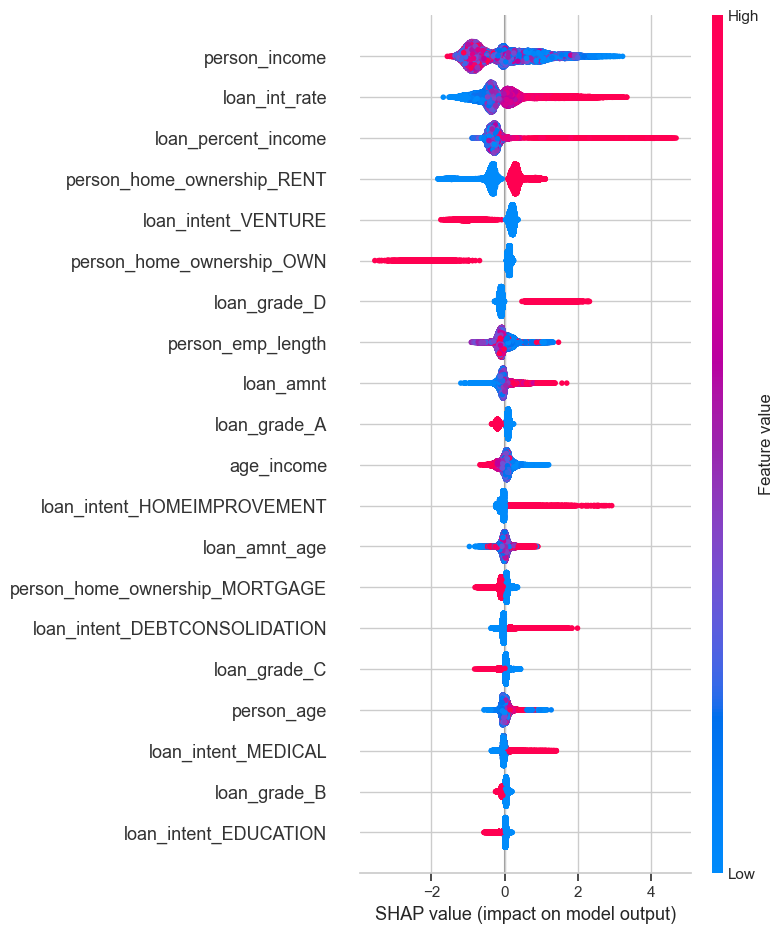

In [105]:
import shap

# 計算 SHAP 值
shap_values = shap.TreeExplainer(lgbm).shap_values(input_meta_df.drop(columns=['id',TARGET]))

# 可視化 SHAP 值
shap.summary_plot(shap_values[1],input_meta_df.drop(columns=['id',TARGET]))



#### Feature Engineering

In [317]:
train_df['mid_risk'] = train_df[['loan_grade', 'person_home_ownership','loan_intent']].apply(
    lambda x: 1 if x['loan_grade'] == 'D' and x['person_home_ownership']=='RENT' and x['loan_intent'] in ['MEDICAL','DEBTCONSOLIDATION'] else 0, axis=1)
train_df['high_risk'] = train_df[['loan_grade', 'person_home_ownership','loan_intent']].apply(
    lambda x: 1 if x['loan_grade'] == 'E' and x['person_home_ownership']=='RENT' and x['loan_intent'] in ['MEDICAL','DEBTCONSOLIDATION'] else 0, axis=1)
train_df['max_risk'] = train_df[['loan_grade', 'person_home_ownership','loan_intent', 'cb_person_default_on_file']].apply(
    lambda x: 1 if x['loan_grade'] == 'D' and x['person_home_ownership']=='RENT' and x['loan_intent'] in ['MEDICAL','DEBTCONSOLIDATION'] and x['cb_person_default_on_file']=='Y' else 0, axis=1)

In [318]:
print(int_columns)
print(float_columns)

['person_age', 'person_income', 'loan_amnt', 'cb_person_cred_hist_length', 'loan_status']
['person_emp_length', 'loan_int_rate', 'loan_percent_income']


In [319]:
use_int = ['person_age', 'person_income', 'loan_amnt', 'cb_person_cred_hist_length']

In [327]:
for i in use_int + float_columns:
    print(i)

person_age
person_income
loan_amnt
cb_person_cred_hist_length
person_emp_length
loan_int_rate
loan_percent_income


##### Cross continuous col with different risk group

In [320]:
for i in ['mid_risk', 'high_risk', 'max_risk']:
    for j in use_int + float_columns:
        train_df[f'{i}_{j}'] = train_df[i] * train_df[j]

In [321]:
train_df

id  person_age  person_income person_home_ownership  \
0          0          37          35000                  RENT   
1          1          22          56000                   OWN   
2          2          29          28800                   OWN   
3          3          30          70000                  RENT   
4          4          22          60000                  RENT   
...      ...         ...            ...                   ...   
58640  58640          34         120000              MORTGAGE   
58641  58641          28          28800                  RENT   
58642  58642          23          44000                  RENT   
58643  58643          22          30000                  RENT   
58644  58644          31          75000              MORTGAGE   

       person_emp_length loan_intent loan_grade  loan_amnt  loan_int_rate  \
0                    0.0   EDUCATION          B       6000          11.49   
1                    6.0     MEDICAL          C       4000          13.35   
2                    8.0    PERSONAL          A       6000           8.90   
3                   14.0     VENTURE          B      12000          11.11   
4                    2.0     MEDICAL          A       6000           6.92   
...                  ...         ...        ...        ...            ...   
58640                5.0   EDUCATION          D      25000          15.95   
58641                0.0     MEDICAL          C      10000          12.73   
58642                7.0   EDUCATION          D       6800          16.00   
58643                2.0   EDUCATION          A       5000           8.90   
58644                2.0     VENTURE          B      15000          11.11   

       loan_percent_income  ... high_risk_person_emp_length  \
0                     0.17  ...                         0.0   
1                     0.07  ...                         0.0   
2                     0.21  ...                         0.0   
3                     0.17  ...                         0.0   
4                     0.10  ...                         0.0   
...                    ...  ...                         ...   
58640                 0.21  ...                         0.0   
58641                 0.35  ...                         0.0   
58642                 0.15  ...                         0.0   
58643                 0.17  ...                         0.0   
58644                 0.20  ...                         0.0   

       high_risk_loan_int_rate  high_risk_loan_percent_income  \
0                          0.0                            0.0   
1                          0.0                            0.0   
2                          0.0                            0.0   
3                          0.0                            0.0   
4                          0.0                            0.0   
...                        ...                            ...   
58640                      0.0                            0.0   
58641                      0.0                            0.0   
58642                      0.0                            0.0   
58643                      0.0                            0.0   
58644                      0.0                            0.0   

       max_risk_person_age  max_risk_person_income  max_risk_loan_amnt  \
0                        0                       0                   0   
1                        0                       0                   0   
2                        0                       0                   0   
3                        0                       0                   0   
4                        0                       0                   0   
...                    ...                     ...                 ...   
58640                    0                       0                   0   
58641                    0                       0                   0   
58642                    0                       0                   0   
58643                    0

In [322]:
train_df.columns

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status', 'mid_risk', 'high_risk',
       'max_risk', 'mid_risk_person_age', 'mid_risk_person_income',
       'mid_risk_loan_amnt', 'mid_risk_cb_person_cred_hist_length',
       'mid_risk_person_emp_length', 'mid_risk_loan_int_rate',
       'mid_risk_loan_percent_income', 'high_risk_person_age',
       'high_risk_person_income', 'high_risk_loan_amnt',
       'high_risk_cb_person_cred_hist_length', 'high_risk_person_emp_length',
       'high_risk_loan_int_rate', 'high_risk_loan_percent_income',
       'max_risk_person_age', 'max_risk_person_income', 'max_risk_loan_amnt',
       'max_risk_cb_person_cred_hist_length', 'max_risk_person_emp_length',
       'max_risk_loan_int_rate', 'max_risk_loan_percent_income'],
      dtype='object')

In [323]:
preprocessor = Preprocessor()
input_df, mapping_df = preprocessor.preprocess(df=train_df,
                                                    one_hot_columns=['loan_grade','person_home_ownership', 'loan_intent', 'cb_person_default_on_file'])
X_train, X_test, y_train, y_test = train_test_split(input_df.drop(columns=['id',TARGET]), input_df[TARGET], test_size=0.3, random_state=42)

lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train)

# trian dataset
y_train_pred = lgbm.predict(X_train)
y_train_proba = lgbm.predict_proba(X_train)[:, 1]

print('Train dataset :')
print(classification_report(y_train, y_train_pred))
print('Confusion matrix :\n',
confusion_matrix(y_train, y_train_pred, labels=[0, 1]))
print('\nAccuracy :', accuracy_score(y_train, y_train_pred))
print('AUC score :', roc_auc_score(y_train, y_train_proba))
print('F1-score :', f1_score(y_train, y_train_pred))
print('Precision score :', precision_score(y_train, y_train_pred))
print('Recall score :', recall_score(y_train, y_train_pred))

# test datset
y_test_pred = lgbm.predict(X_test)
y_test_proba = lgbm.predict_proba(X_test)[:, 1]

print('\n\nTest dataset :')
print(classification_report(y_test, y_test_pred))
print('Confusion matrix :\n',
confusion_matrix(y_test, y_test_pred, labels=[0, 1]))
print('\nAccuracy :', accuracy_score(y_test, y_test_pred))
print('AUC score :', roc_auc_score(y_test, y_test_proba))
print('F1-score :', f1_score(y_test, y_test_pred))
print('Precision score :', precision_score(y_test, y_test_pred))
print('Recall score :', recall_score(y_test, y_test_pred))

[LightGBM] [Info] Number of positive: 5882, number of negative: 35169
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1604
[LightGBM] [Info] Number of data points in the train set: 41051, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143285 -> initscore=-1.788268
[LightGBM] [Info] Start training from score -1.788268
Train dataset :
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     35169
           1       0.95      0.74      0.83      5882

    accuracy                           0.96     41051
   macro avg       0.95      0.87      0.90     41051
weighted avg       0.96      0.96      0.95     41051

Confusion matrix :
 [[34919   250]
 [ 1517  4365]]

Accuracy : 0.9569559815838835
AUC score : 0.9765

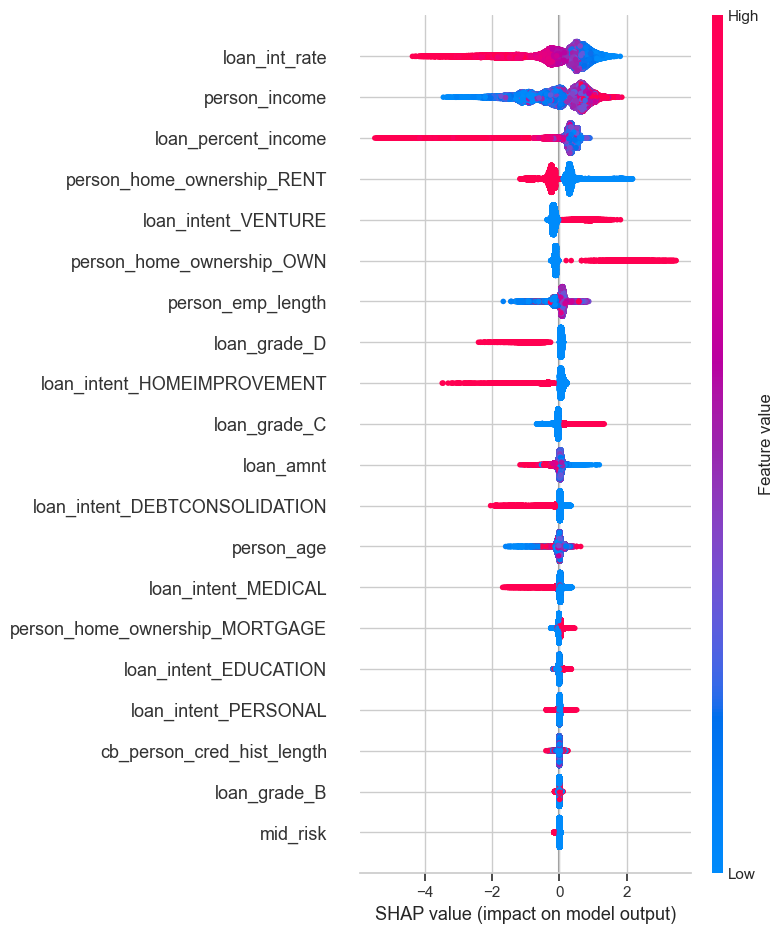

In [235]:
# # 計算 SHAP 值
# shap_values = shap.TreeExplainer(lgbm).shap_values(input_df.drop(columns=['id',TARGET]))

# # 可視化 SHAP 值
# shap.summary_plot(shap_values[0],input_df.drop(columns=['id',TARGET]))


In [328]:
input_df

id  person_age  person_income  person_emp_length  loan_amnt  \
0          0          37          35000                0.0       6000   
1          1          22          56000                6.0       4000   
2          2          29          28800                8.0       6000   
3          3          30          70000               14.0      12000   
4          4          22          60000                2.0       6000   
...      ...         ...            ...                ...        ...   
58640  58640          34         120000                5.0      25000   
58641  58641          28          28800                0.0      10000   
58642  58642          23          44000                7.0       6800   
58643  58643          22          30000                2.0       5000   
58644  58644          31          75000                2.0      15000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
0              11.49                 0.17                          14   
1              13.35                 0.07                           2   
2               8.90                 0.21                          10   
3              11.11                 0.17                           5   
4               6.92                 0.10                           3   
...              ...                  ...                         ...   
58640          15.95                 0.21                          10   
58641          12.73                 0.35                           8   
58642          16.00                 0.15                           2   
58643           8.90                 0.17                           3   
58644          11.11                 0.20                           5   

       loan_status  mid_risk  ...  person_home_ownership_OWN  \
0                0         0  ...                        0.0   
1                0         0  ...                        1.0   
2                0         0  ...                        1.0   
3                0         0  ...                        0.0   
4                0         0  ...                        0.0   
...            ...       ...  ...                        ...   
58640            0         0  ...                        0.0   
58641            1         0  ...                        0.0   
58642            1         0  ...                        0.0   
58643            0         0  ...                        0.0   
58644            0         0  ...                        0.0   

       person_home_ownership_RENT  loan_intent_DEBTCONSOLIDATION  \
0                             1.0                            0.0   
1                             0.0                            0.0   
2                             0.0                            0.0   
3                             1.0                            0.0   
4                             1.0                            0.0   
...                           ...                            ...   
58640                         0.0                            0.0   
58641                         1.0                            0.0   
58642                         1.0                            0.0   
58643                         1.0                            0.0   
58644                         0.0                            0.0   

       loan_intent_EDUCATION  loan_intent_HOMEIMPROVEMENT  \
0                        1.0                          0.0   
1                        0.0                          0.0   
2                        0.0                          0.0   
3                        0.0                          0.0   
4                        0.0                          0.0   
...                      ...                          ...   
58640                    1.0                          0.0   
58641                    0.0                          0.0   
58642                    1.0                          0.0   
58643                    1.0                          0.0   

#### Model building

In [332]:
# from sklearn.ensemble import StackingClassifier
# from sklearn.linear_model import LogisticRegression
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# from sklearn.model_selection import train_test_split, cross_val_score
# from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
# import numpy as np
# import os
# import pickle

# # 定義目標函數
# def objective(params):
#     lgbm = LGBMClassifier(
#         n_estimators=int(params['lgbm_n_estimators']),
#         learning_rate=params['lgbm_learning_rate'],
#         num_leaves=int(params['lgbm_num_leaves']),
#         max_depth=int(params['lgbm_max_depth']),
#         min_child_samples=int(params['lgbm_min_child_samples']),
#         subsample=params['lgbm_subsample'],
#         colsample_bytree=params['lgbm_colsample_bytree'],
#         random_state=42
#     )
#     cat = CatBoostClassifier(
#         iterations=int(params['cat_iterations']),
#         learning_rate=params['cat_learning_rate'],
#         depth=int(params['cat_depth']),
#         l2_leaf_reg=params['cat_l2_leaf_reg'],
#         verbose=0,
#         random_state=42
#     )
#     meta_model = LogisticRegression(C=params['meta_C'], random_state=42)
    
#     stack = StackingClassifier(
#         estimators=[('lgbm', lgbm), ('cat', cat)],
#         final_estimator=meta_model,
#         passthrough=False,
#         cv=5,
#         n_jobs=-1
#     )
    
#     score = cross_val_score(stack, X_train, y_train, cv=5, scoring='roc_auc').mean()
#     return {'loss': -score, 'status': STATUS_OK}

# # 定義搜索空間
# space = {
#     'lgbm_n_estimators': hp.quniform('lgbm_n_estimators', 100, 1000, 50),
#     'lgbm_learning_rate': hp.uniform('lgbm_learning_rate', 0.01, 0.3),
#     'lgbm_num_leaves': hp.quniform('lgbm_num_leaves', 31, 255, 1),
#     'lgbm_max_depth': hp.quniform('lgbm_max_depth', -1, 15, 1),
#     'lgbm_min_child_samples': hp.quniform('lgbm_min_child_samples', 20, 100, 1),
#     'lgbm_subsample': hp.uniform('lgbm_subsample', 0.5, 1.0),
#     'lgbm_colsample_bytree': hp.uniform('lgbm_colsample_bytree', 0.5, 1.0),
#     'cat_iterations': hp.quniform('cat_iterations', 100, 1000, 50),
#     'cat_learning_rate': hp.uniform('cat_learning_rate', 0.01, 0.3),
#     'cat_depth': hp.quniform('cat_depth', 4, 10, 1),
#     'cat_l2_leaf_reg': hp.uniform('cat_l2_leaf_reg', 1, 10),
#     'meta_C': hp.loguniform('meta_C', np.log(0.01), np.log(10))
# }

# # 儲存試驗結果的檔案路徑
# trials_save_file = 'hyperopt_trials.pkl'

# # 嘗試從檔案中載入試驗結果
# if os.path.exists(trials_save_file):
#     with open(trials_save_file, 'rb') as f:
#         trials = pickle.load(f)
# else:
#     trials = Trials()

# # 使用 TPE 進行超參數調整
# best = fmin(fn=objective,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=50,
#             trials=trials)

# # 儲存試驗結果到檔案
# with open(trials_save_file, 'wb') as f:
#     pickle.dump(trials, f)


In [333]:
# print("Best parameters found: ", best)

In [334]:
# # 使用最佳參數來訓練最終模型
# best_lgbm = LGBMClassifier(
#     n_estimators=int(best['lgbm_n_estimators']),
#     learning_rate=best['lgbm_learning_rate'],
#     num_leaves=int(best['lgbm_num_leaves']),
#     max_depth=int(best['lgbm_max_depth']),
#     min_child_samples=int(best['lgbm_min_child_samples']),
#     subsample=best['lgbm_subsample'],
#     colsample_bytree=best['lgbm_colsample_bytree'],
#     random_state=42
# )
# best_cat = CatBoostClassifier(
#     iterations=int(best['cat_iterations']),
#     learning_rate=best['cat_learning_rate'],
#     depth=int(best['cat_depth']),
#     l2_leaf_reg=best['cat_l2_leaf_reg'],
#     border_count=int(best['cat_border_count']),
#     verbose=0,
#     random_state=42
# )
# best_meta_model = LogisticRegression(C=best['meta_C'], random_state=42)

# best_stack = StackingClassifier(
#     estimators=[('lgbm', best_lgbm), ('cat', best_cat)],
#     final_estimator=best_meta_model,
#     passthrough=False,
#     cv=5,
#     n_jobs=-1
# )

# # 訓練最終模型
# best_stack.fit(X_train, y_train)

In [336]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import make_classification
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import numpy as np
import os
import pickle


# 定義目標函數
def objective(params):
    lgbm = LGBMClassifier(
        n_estimators=int(params['lgbm_n_estimators']),
        learning_rate=params['lgbm_learning_rate'],
        random_state=42
    )
    cat = CatBoostClassifier(
        iterations=int(params['cat_iterations']),
        learning_rate=params['cat_learning_rate'],
        depth=int(params['cat_depth']),
        verbose=0,
        random_state=42
    )
    meta_model = LogisticRegression(C=params['meta_C'], random_state=42)
    
    stack = StackingClassifier(
        estimators=[('lgbm', lgbm), ('cat', cat)],
        final_estimator=meta_model,
        passthrough=False,
        cv=5,
        n_jobs=-1
    )
    
    score = cross_val_score(stack, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return {'loss': -score, 'status': STATUS_OK}

# 定義搜索空間
space = {
    'lgbm_n_estimators': hp.quniform('lgbm_n_estimators', 100, 1000, 1),
    'lgbm_learning_rate': hp.uniform('lgbm_learning_rate', 0.01, 0.3),
    'cat_iterations': hp.quniform('cat_iterations', 100, 1000, 1),
    'cat_learning_rate': hp.uniform('cat_learning_rate', 0.01, 0.3),
    'cat_depth': hp.quniform('cat_depth', 4, 10, 1),
    'meta_C': hp.loguniform('meta_C', np.log(0.1), np.log(10))
}

# 儲存試驗結果的檔案路徑
trials_save_file = 'hyperopt_trials.pkl'

# # 嘗試從檔案中載入試驗結果
# if os.path.exists(trials_save_file):
#     with open(trials_save_file, 'rb') as f:
#         trials = pickle.load(f)
# else:
#     trials = Trials()

trials = Trials()

# 使用 TPE 進行超參數調整
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

# # 儲存試驗結果到檔案
# with open(trials_save_file, 'wb') as f:
#     pickle.dump(trials, f)




  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

2024-10-14 17:06:50,678 - INFO - build_posterior_wrapper took 0.004008 seconds
2024-10-14 17:06:50,680 - INFO - TPE using 0 trials


  3%|▎         | 1/30 [01:52<54:17, 112.34s/trial, best loss: -0.9473601902661251]

2024-10-14 17:08:43,012 - INFO - build_posterior_wrapper took 0.001997 seconds
2024-10-14 17:08:43,013 - INFO - TPE using 1/1 trials with best loss -0.947360


  7%|▋         | 2/30 [05:05<1:14:33, 159.78s/trial, best loss: -0.9541275796086536]

2024-10-14 17:11:56,006 - INFO - build_posterior_wrapper took 0.002100 seconds
2024-10-14 17:11:56,008 - INFO - TPE using 2/2 trials with best loss -0.954128


 10%|█         | 3/30 [10:39<1:47:39, 239.23s/trial, best loss: -0.9541275796086536]

2024-10-14 17:17:29,780 - INFO - build_posterior_wrapper took 0.002000 seconds
2024-10-14 17:17:29,782 - INFO - TPE using 2/3 trials with best loss -0.954128


 13%|█▎        | 4/30 [14:33<1:42:45, 237.14s/trial, best loss: -0.9541275796086536]

2024-10-14 17:21:23,729 - INFO - build_posterior_wrapper took 0.002996 seconds
2024-10-14 17:21:23,730 - INFO - TPE using 3/4 trials with best loss -0.954128


 17%|█▋        | 5/30 [16:22<1:19:34, 190.98s/trial, best loss: -0.9541275796086536]

2024-10-14 17:23:12,849 - INFO - build_posterior_wrapper took 0.001998 seconds
2024-10-14 17:23:12,850 - INFO - TPE using 4/5 trials with best loss -0.954128


 20%|██        | 6/30 [17:30<59:45, 149.40s/trial, best loss: -0.9541275796086536]  

2024-10-14 17:24:21,524 - INFO - build_posterior_wrapper took 0.001993 seconds
2024-10-14 17:24:21,525 - INFO - TPE using 5/6 trials with best loss -0.954128


 23%|██▎       | 7/30 [20:16<59:16, 154.64s/trial, best loss: -0.9541275796086536]

2024-10-14 17:27:06,966 - INFO - build_posterior_wrapper took 0.002000 seconds
2024-10-14 17:27:06,967 - INFO - TPE using 6/7 trials with best loss -0.954128


 27%|██▋       | 8/30 [21:51<49:47, 135.82s/trial, best loss: -0.9554238796300284]

2024-10-14 17:28:42,475 - INFO - build_posterior_wrapper took 0.001998 seconds
2024-10-14 17:28:42,476 - INFO - TPE using 7/8 trials with best loss -0.955424


 30%|███       | 9/30 [24:14<48:16, 137.91s/trial, best loss: -0.9554238796300284]

2024-10-14 17:31:05,001 - INFO - build_posterior_wrapper took 0.002000 seconds
2024-10-14 17:31:05,002 - INFO - TPE using 8/9 trials with best loss -0.955424


 33%|███▎      | 10/30 [36:17<1:46:11, 318.58s/trial, best loss: -0.9554238796300284]

2024-10-14 17:43:08,138 - INFO - build_posterior_wrapper took 0.002001 seconds
2024-10-14 17:43:08,139 - INFO - TPE using 9/10 trials with best loss -0.955424


 37%|███▋      | 11/30 [36:52<1:13:26, 231.91s/trial, best loss: -0.9554238796300284]

2024-10-14 17:43:43,512 - INFO - build_posterior_wrapper took 0.002010 seconds
2024-10-14 17:43:43,513 - INFO - TPE using 10/11 trials with best loss -0.955424


 40%|████      | 12/30 [38:10<55:30, 185.04s/trial, best loss: -0.9554238796300284]  

2024-10-14 17:45:01,359 - INFO - build_posterior_wrapper took 0.002000 seconds
2024-10-14 17:45:01,360 - INFO - TPE using 11/12 trials with best loss -0.955424


 43%|████▎     | 13/30 [38:54<40:18, 142.25s/trial, best loss: -0.9554238796300284]

2024-10-14 17:45:45,152 - INFO - build_posterior_wrapper took 0.001997 seconds
2024-10-14 17:45:45,153 - INFO - TPE using 12/13 trials with best loss -0.955424


 47%|████▋     | 14/30 [43:23<48:06, 180.43s/trial, best loss: -0.9554238796300284]

2024-10-14 17:50:13,800 - INFO - build_posterior_wrapper took 0.000999 seconds
2024-10-14 17:50:13,801 - INFO - TPE using 13/14 trials with best loss -0.955424


 50%|█████     | 15/30 [44:55<38:29, 154.00s/trial, best loss: -0.9554238796300284]

2024-10-14 17:51:46,542 - INFO - build_posterior_wrapper took 0.002000 seconds
2024-10-14 17:51:46,543 - INFO - TPE using 14/15 trials with best loss -0.955424


 53%|█████▎    | 16/30 [46:48<33:02, 141.63s/trial, best loss: -0.9554238796300284]

2024-10-14 17:53:39,458 - INFO - build_posterior_wrapper took 0.002000 seconds
2024-10-14 17:53:39,459 - INFO - TPE using 15/16 trials with best loss -0.955424


 57%|█████▋    | 17/30 [50:11<34:38, 159.92s/trial, best loss: -0.9554238796300284]

2024-10-14 17:57:01,897 - INFO - build_posterior_wrapper took 0.002000 seconds
2024-10-14 17:57:01,898 - INFO - TPE using 16/17 trials with best loss -0.955424


 60%|██████    | 18/30 [51:17<26:22, 131.92s/trial, best loss: -0.9554238796300284]

2024-10-14 17:58:08,627 - INFO - build_posterior_wrapper took 0.002000 seconds
2024-10-14 17:58:08,628 - INFO - TPE using 17/18 trials with best loss -0.955424


 63%|██████▎   | 19/30 [54:28<27:26, 149.65s/trial, best loss: -0.9554238796300284]

2024-10-14 18:01:19,606 - INFO - build_posterior_wrapper took 0.002000 seconds
2024-10-14 18:01:19,607 - INFO - TPE using 18/19 trials with best loss -0.955424


 67%|██████▋   | 20/30 [1:03:14<43:44, 262.49s/trial, best loss: -0.9554238796300284]

2024-10-14 18:10:05,066 - INFO - build_posterior_wrapper took 0.000999 seconds
2024-10-14 18:10:05,067 - INFO - TPE using 19/20 trials with best loss -0.955424


 70%|███████   | 21/30 [1:04:36<31:15, 208.40s/trial, best loss: -0.9554238796300284]

2024-10-14 18:11:27,364 - INFO - build_posterior_wrapper took 0.002000 seconds
2024-10-14 18:11:27,365 - INFO - TPE using 20/21 trials with best loss -0.955424


 73%|███████▎  | 22/30 [1:05:56<22:37, 169.72s/trial, best loss: -0.9554238796300284]

2024-10-14 18:12:46,886 - INFO - build_posterior_wrapper took 0.002001 seconds
2024-10-14 18:12:46,886 - INFO - TPE using 21/22 trials with best loss -0.955424


 77%|███████▋  | 23/30 [1:07:19<16:45, 143.69s/trial, best loss: -0.9554238796300284]

2024-10-14 18:14:09,850 - INFO - build_posterior_wrapper took 0.002001 seconds
2024-10-14 18:14:09,851 - INFO - TPE using 22/23 trials with best loss -0.955424


 80%|████████  | 24/30 [1:08:30<12:12, 122.05s/trial, best loss: -0.9554238796300284]

2024-10-14 18:15:21,443 - INFO - build_posterior_wrapper took 0.001000 seconds
2024-10-14 18:15:21,444 - INFO - TPE using 23/24 trials with best loss -0.955424


 83%|████████▎ | 25/30 [1:10:28<10:03, 120.67s/trial, best loss: -0.9555978303966575]

2024-10-14 18:17:18,894 - INFO - build_posterior_wrapper took 0.001999 seconds
2024-10-14 18:17:18,895 - INFO - TPE using 24/25 trials with best loss -0.955598


 87%|████████▋ | 26/30 [1:12:39<08:15, 123.90s/trial, best loss: -0.9555978303966575]

2024-10-14 18:19:30,311 - INFO - build_posterior_wrapper took 0.001999 seconds
2024-10-14 18:19:30,312 - INFO - TPE using 25/26 trials with best loss -0.955598


 90%|█████████ | 27/30 [1:14:26<05:56, 118.75s/trial, best loss: -0.9561991873706311]

2024-10-14 18:21:17,054 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-10-14 18:21:17,055 - INFO - TPE using 26/27 trials with best loss -0.956199


 93%|█████████▎| 28/30 [1:16:22<03:55, 117.87s/trial, best loss: -0.9561991873706311]

2024-10-14 18:23:12,877 - INFO - build_posterior_wrapper took 0.001999 seconds
2024-10-14 18:23:12,878 - INFO - TPE using 27/28 trials with best loss -0.956199


 97%|█████████▋| 29/30 [1:17:51<01:49, 109.27s/trial, best loss: -0.9561991873706311]

2024-10-14 18:24:42,087 - INFO - build_posterior_wrapper took 0.001999 seconds
2024-10-14 18:24:42,089 - INFO - TPE using 28/29 trials with best loss -0.956199


100%|██████████| 30/30 [1:19:58<00:00, 159.94s/trial, best loss: -0.9561991873706311]


In [337]:
print("Best parameters found: ", best)

Best parameters found:  {'cat_depth': 4.0, 'cat_iterations': 788.0, 'cat_learning_rate': 0.11737867580887024, 'lgbm_learning_rate': 0.07005308570813606, 'lgbm_n_estimators': 231.0, 'meta_C': 1.072064459629542}


In [343]:
import json

# 將最佳參數儲存為 JSON 檔案
with open('best_params.json', 'w') as json_file:
    json.dump(best, json_file)

print("Best parameters saved to best_params.json")

Best parameters saved to best_params.json


In [338]:
best_lgbm = LGBMClassifier(
    n_estimators=int(best['lgbm_n_estimators']),
    learning_rate=best['lgbm_learning_rate'],
    random_state=42
)
best_cat = CatBoostClassifier(
    iterations=int(best['cat_iterations']),
    learning_rate=best['cat_learning_rate'],
    depth=int(best['cat_depth']),
    verbose=0,
    random_state=42
)
best_meta_model = LogisticRegression(C=best['meta_C'], random_state=42)

best_stack = StackingClassifier(
    estimators=[('lgbm', best_lgbm), ('cat', best_cat)],
    final_estimator=best_meta_model,
    passthrough=False,
    cv=5,
    n_jobs=-1
)


In [339]:
best_stack.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lgbm',
                                LGBMClassifier(learning_rate=0.07005308570813606,
                                               n_estimators=231,
                                               random_state=42)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x000001FE7AF660D0>)],
                   final_estimator=LogisticRegression(C=1.072064459629542,
                                                      random_state=42),
                   n_jobs=-1)

In [340]:
# trian dataset
y_train_pred = best_stack.predict(X_train)
y_train_proba = best_stack.predict_proba(X_train)[:, 1]

print('Train dataset :')
print(classification_report(y_train, y_train_pred))
print('Confusion matrix :\n',
confusion_matrix(y_train, y_train_pred, labels=[0, 1]))
print('\nAccuracy :', accuracy_score(y_train, y_train_pred))
print('AUC score :', roc_auc_score(y_train, y_train_proba))
print('F1-score :', f1_score(y_train, y_train_pred))
print('Precision score :', precision_score(y_train, y_train_pred))
print('Recall score :', recall_score(y_train, y_train_pred))

# test datset
y_test_pred = best_stack.predict(X_test)
y_test_proba = best_stack.predict_proba(X_test)[:, 1]

print('\n\nTest dataset :')
print(classification_report(y_test, y_test_pred))
print('Confusion matrix :\n',
confusion_matrix(y_test, y_test_pred, labels=[0, 1]))
print('\nAccuracy :', accuracy_score(y_test, y_test_pred))
print('AUC score :', roc_auc_score(y_test, y_test_proba))
print('F1-score :', f1_score(y_test, y_test_pred))
print('Precision score :', precision_score(y_test, y_test_pred))
print('Recall score :', recall_score(y_test, y_test_pred))

Train dataset :
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     35169
           1       0.95      0.76      0.85      5882

    accuracy                           0.96     41051
   macro avg       0.96      0.88      0.91     41051
weighted avg       0.96      0.96      0.96     41051

Confusion matrix :
 [[34946   223]
 [ 1399  4483]]

Accuracy : 0.9604881732479111
AUC score : 0.9793043313498182
F1-score : 0.8468077068379297
Precision score : 0.9526136846578835
Recall score : 0.7621557293437606


Test dataset :
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     15126
           1       0.91      0.74      0.82      2468

    accuracy                           0.95     17594
   macro avg       0.93      0.86      0.90     17594
weighted avg       0.95      0.95      0.95     17594

Confusion matrix :
 [[14947   179]
 [  641  1827]]

Accuracy : 0.9533932022280323
AUC score : 0.957

Train dataset :
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     35169
           1       0.95      0.74      0.83      5882

    accuracy                           0.96     41051
   macro avg       0.95      0.87      0.90     41051
weighted avg       0.96      0.96      0.95     41051

Confusion matrix :
 [[34919   250]
 [ 1534  4348]]

Accuracy : 0.9565418625612043
AUC score : 0.9776059551147354
F1-score : 0.8297709923664122
Precision score : 0.9456285341452806
Recall score : 0.7392043522611357


Test dataset :
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     15126
           1       0.92      0.73      0.81      2468

    accuracy                           0.95     17594
   macro avg       0.94      0.86      0.89     17594
weighted avg       0.95      0.95      0.95     17594

Confusion matrix :
 [[14973   153]
 [  668  1800]]

Accuracy : 0.9533363646697738
AUC score : 0.9561720312208352
F1-score : 0.81429540827867
Precision score : 0.9216589861751152
Recall score : 0.7293354943273906

In [341]:
best_lgbm.fit(X_train, y_train)
best_cat.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 5882, number of negative: 35169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1604
[LightGBM] [Info] Number of data points in the train set: 41051, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143285 -> initscore=-1.788268
[LightGBM] [Info] Start training from score -1.788268


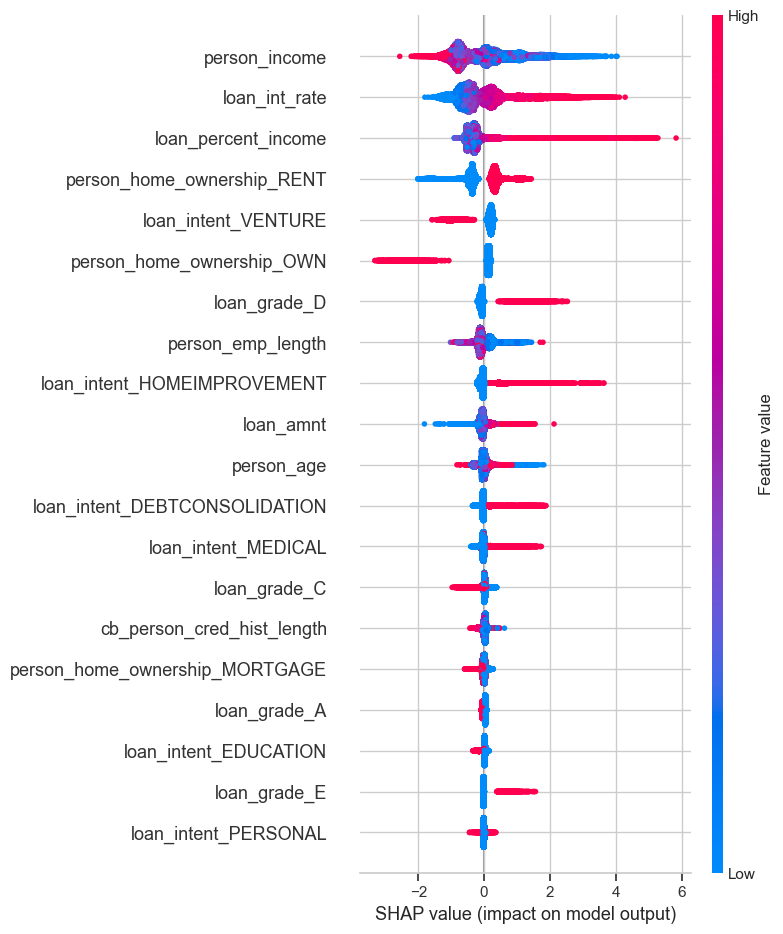

In [344]:
import shap

# 使用 SHAP 來解釋模型
explainer_lgbm = shap.TreeExplainer(best_lgbm)
shap_values_lgbm = explainer_lgbm.shap_values(input_df.drop(columns=['id',TARGET]))

explainer_cat = shap.TreeExplainer(best_cat)
shap_values_cat = explainer_cat.shap_values(input_df.drop(columns=['id',TARGET]))

# 合併 SHAP 值
shap_values_combined = np.mean([shap_values_lgbm, shap_values_cat], axis=0)

# 繪製 SHAP 值
shap.summary_plot(shap_values_combined[1], input_df.drop(columns=['id',TARGET]))

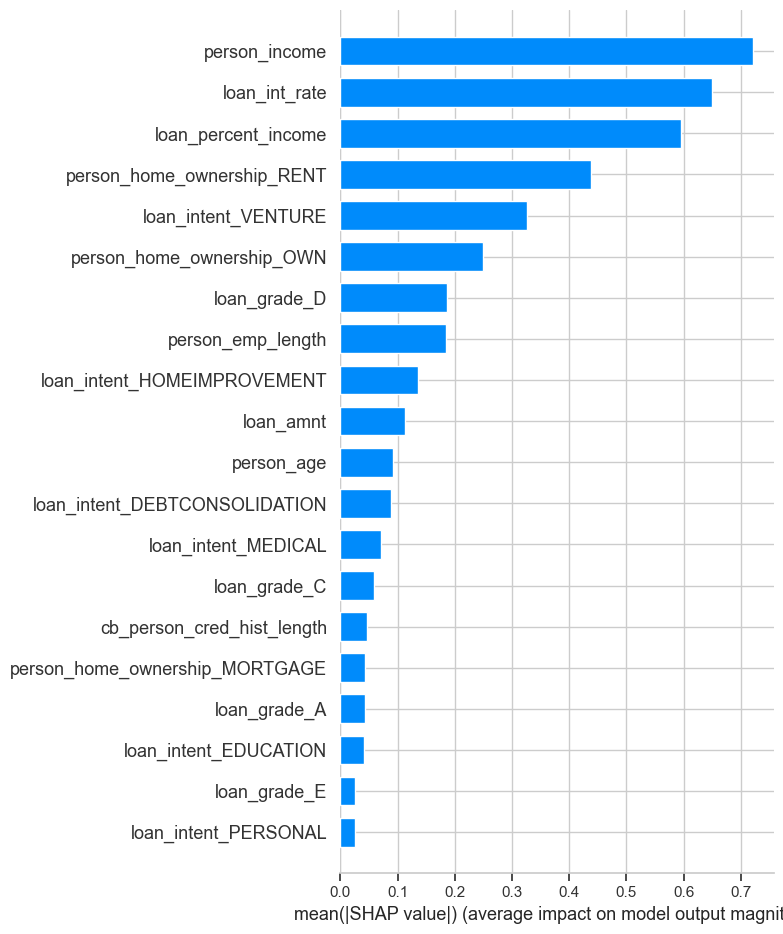

In [371]:
# 繪製 SHAP 值
shap.summary_plot(shap_values_combined[1], input_df.drop(columns=['id',TARGET]), plot_type='bar')

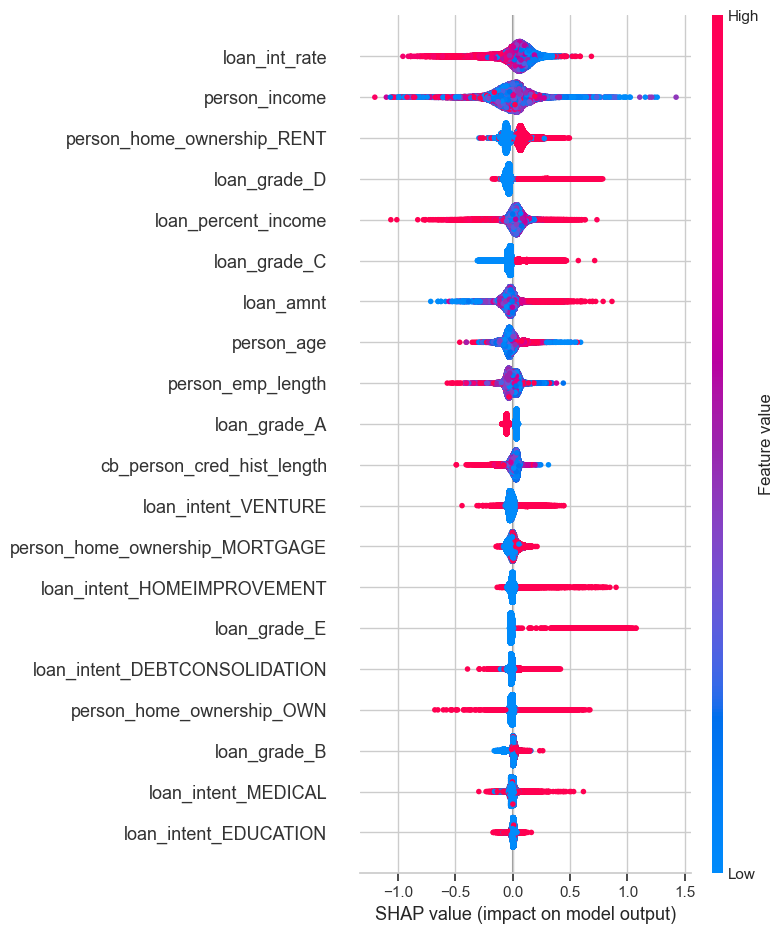

In [345]:
# 繪製 SHAP 值
shap.summary_plot(shap_values_combined[0], input_df.drop(columns=['id',TARGET]))

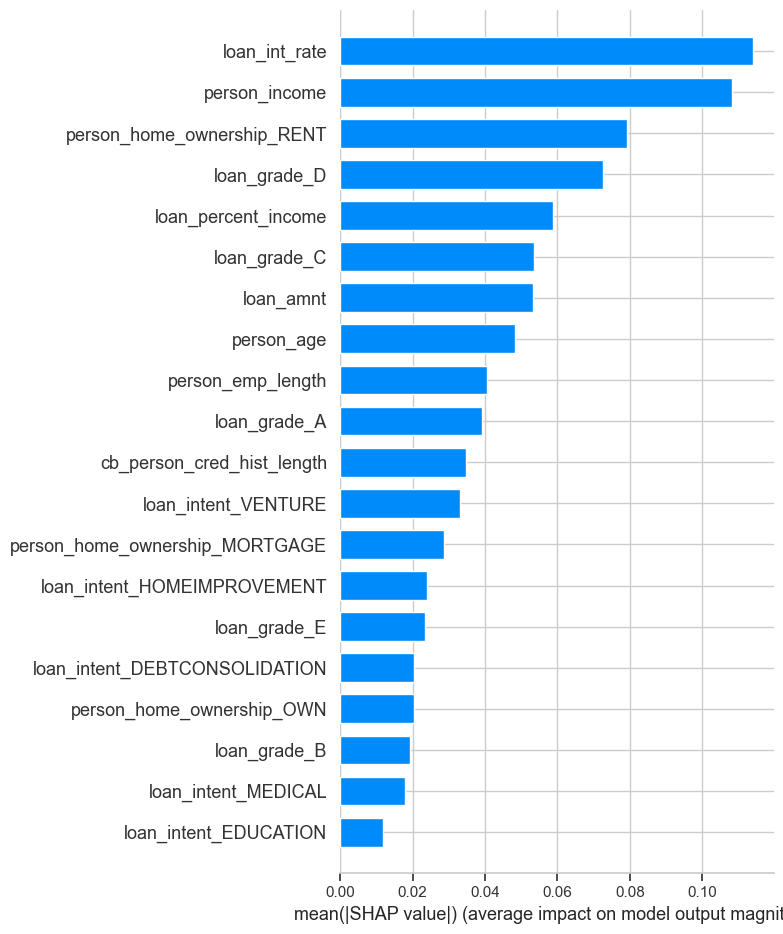

In [370]:
# 繪製 SHAP 值
shap.summary_plot(shap_values_combined[0], input_df.drop(columns=['id',TARGET]), plot_type='bar')

In [348]:
input_df.drop(columns=['id',TARGET]).columns

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'mid_risk', 'high_risk', 'max_risk', 'mid_risk_person_age',
       'mid_risk_person_income', 'mid_risk_loan_amnt',
       'mid_risk_cb_person_cred_hist_length', 'mid_risk_person_emp_length',
       'mid_risk_loan_int_rate', 'mid_risk_loan_percent_income',
       'high_risk_person_age', 'high_risk_person_income',
       'high_risk_loan_amnt', 'high_risk_cb_person_cred_hist_length',
       'high_risk_person_emp_length', 'high_risk_loan_int_rate',
       'high_risk_loan_percent_income', 'max_risk_person_age',
       'max_risk_person_income', 'max_risk_loan_amnt',
       'max_risk_cb_person_cred_hist_length', 'max_risk_person_emp_length',
       'max_risk_loan_int_rate', 'max_risk_loan_percent_income',
       'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D',
       'loan_grade_E', 'loan_grade_F', 'loan_grade_G',
       'pe

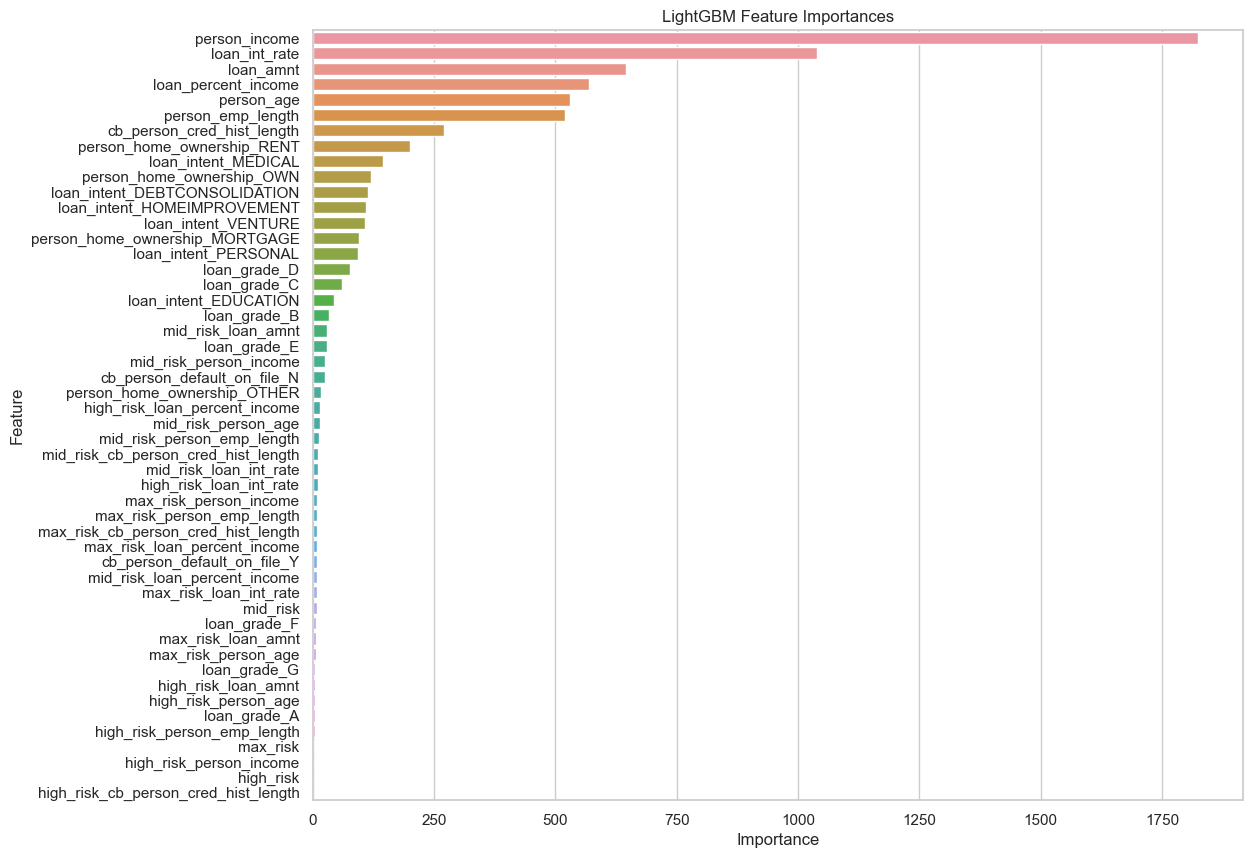

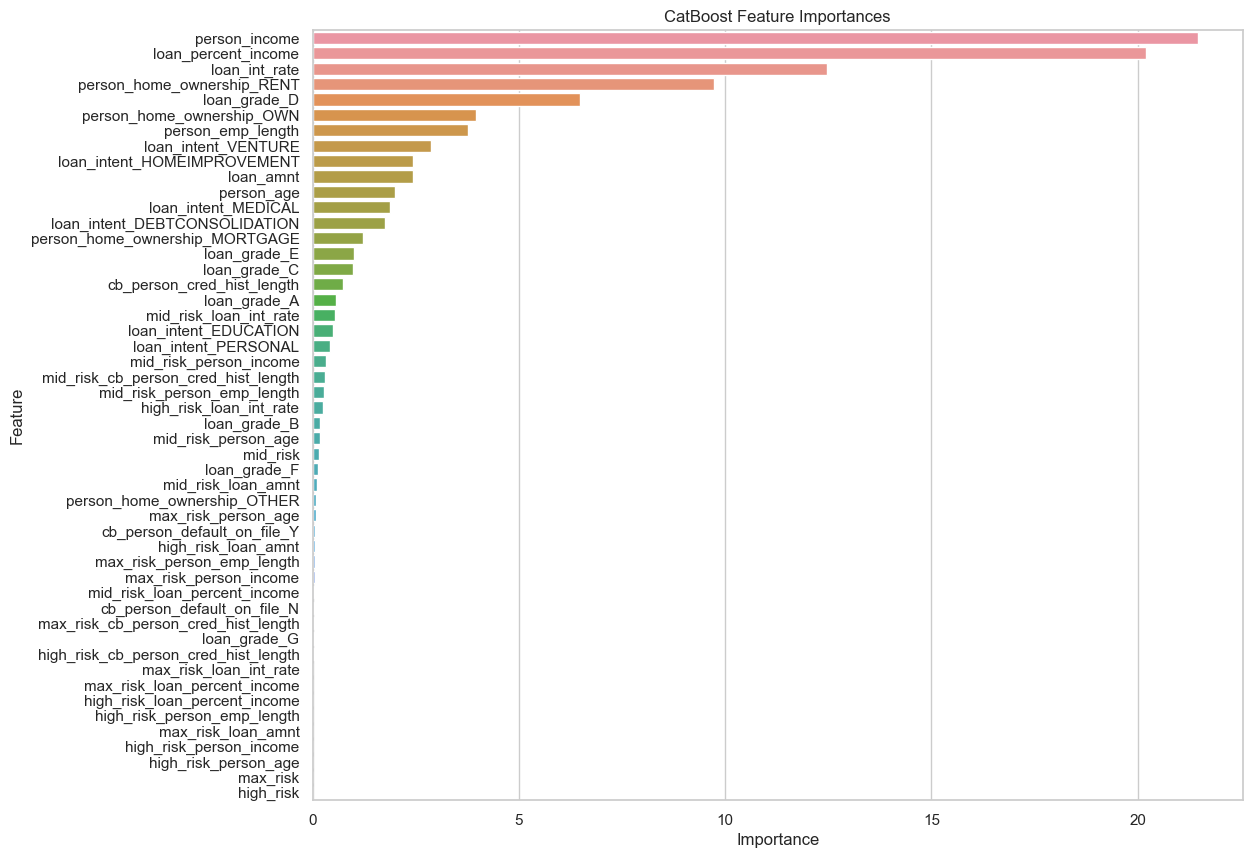

In [350]:
import seaborn as sns

import matplotlib.pyplot as plt

# Extract feature importances from the LightGBM model
lgbm_importances = best_lgbm.feature_importances_
lgbm_features = X_train.columns

# Extract feature importances from the CatBoost model
cat_importances = best_cat.get_feature_importance()
cat_features = X_train.columns

# Create a DataFrame for LightGBM feature importances
lgbm_importance_df = pd.DataFrame({
    'Feature': lgbm_features,
    'Importance': lgbm_importances
}).sort_values(by='Importance', ascending=False)

# Create a DataFrame for CatBoost feature importances
cat_importance_df = pd.DataFrame({
    'Feature': cat_features,
    'Importance': cat_importances
}).sort_values(by='Importance', ascending=False)

# Plot LightGBM feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=lgbm_importance_df)
plt.title('LightGBM Feature Importances')
plt.show()

# Plot CatBoost feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=cat_importance_df)
plt.title('CatBoost Feature Importances')
plt.show()

In [366]:
y_proba = best_stack.predict_proba(input_df.drop(columns=['id',TARGET]))[:, 1]
y_test = input_df[TARGET]

# 計算不同閥值下的 Precision、Recall 和 Accuracy
thresholds = np.arange(0, 1.01, 0.01).round(5)
results = []

for threshold in thresholds:
    y_pred = (y_proba >= threshold).astype(int)
    precision = round(precision_score(y_test, y_pred),5)
    recall = round(recall_score(y_test, y_pred),5)
    accuracy = round(accuracy_score(y_test, y_pred),5)
    results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy
    })

# 將結果轉換為 DataFrame
results_df = pd.DataFrame(results)

In [367]:
# 輸出結果
results_df.to_csv('threshold_results.csv', index=False)

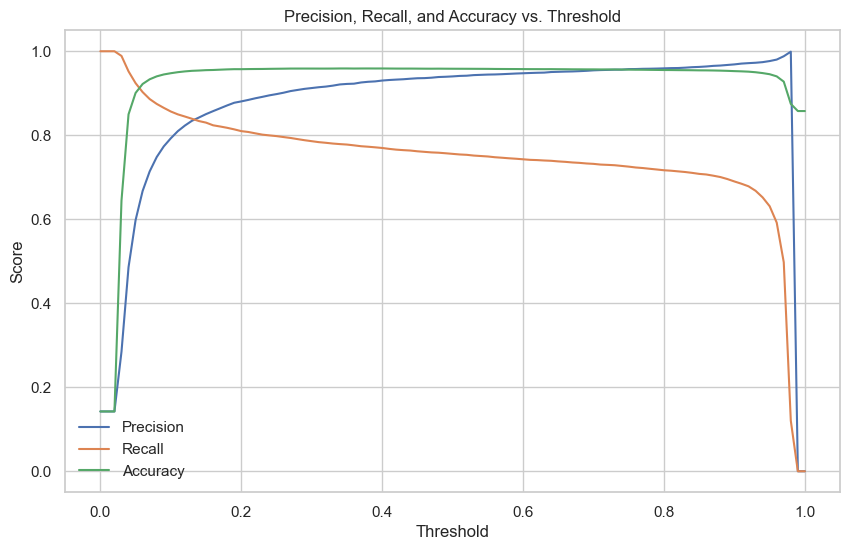

In [368]:
# 繪製圖表
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='threshold', y='precision', label='Precision')
sns.lineplot(data=results_df, x='threshold', y='recall', label='Recall')
sns.lineplot(data=results_df, x='threshold', y='accuracy', label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and Accuracy vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

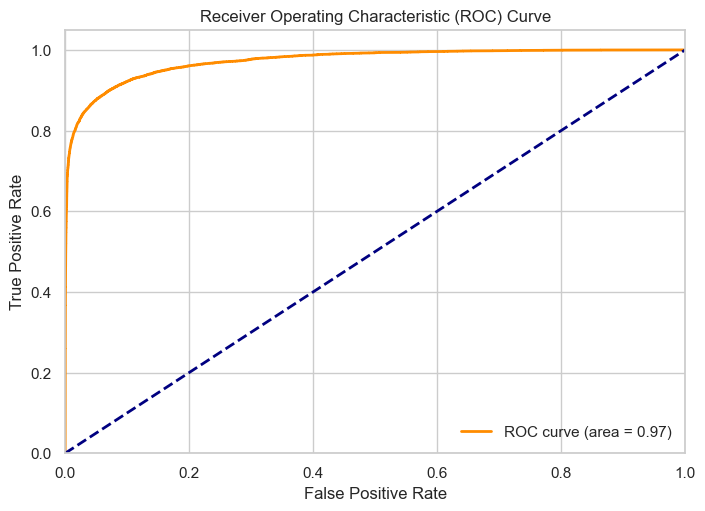

In [369]:
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt


# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()